# Asset Management Project

In this project, im using the following libraries:

- `pandas` for data manipulation
- `numpy` for numerical operations
- `matplotlib` for plotting
- `seaborn` for having a better visualization
- `scipy` for statistics and optimization
- `datetime` for dates and times
- `ffn` for financial functions
- `yfinance` for downloading historical stock prices
- `xgboost` for machine learning
- `sklearn` for machine learning
- `skopt` for hyperparameter optimization

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import ffn 
import os
import yfinance as yf
import scipy.optimize as sco
import pandas as pd
import seaborn as sns
import datetime as dt
from dateutil.relativedelta import relativedelta
from collections import namedtuple
from typing import Optional, Tuple, Dict, Any, List

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, make_scorer
from skopt import BayesSearchCV

sns.set(style='darkgrid')
sns.mpl.rc('figure', figsize=(7, 5))
sns.mpl.rc('font', size = 12)

# pd.set_option('display.max_columns', 100)

---

# Dynamic Portfolio

I will divide the project into two. The first part is going to consist about the dynamic portfolio, the second is going to be dedicated for the Patrimonial portfolio.

## Investment Universe & Selection

Im going to retrieve some famous stocks, commodities from the Yahoo Finance API. The stocks are going to be the following:

In [14]:
industries = {
    "Technology": ["ASML.AS", "SAP.DE", "IFX.DE", "STMPA.PA", "NOKIA.HE", "ERIC-B.ST"],
    "Healthcare": ["SAN.PA", "NVO", "AZN.L", "GSK.L", "NOVN.SW", "BAYN.DE"],
    "Renewable Energy": ["ENR.DE", "ENEL.MI", "ORSTED.CO", "VWS.CO", "EDPR.LS", "EOAN.DE"],
    "Consumer Staples": ["ULVR.L", "BN.PA", "ABI.BR", "NESN.SW", "HEIA.AS", "RKT.L"],
    "Utilities": ["ENGI.PA", "RWE.DE", "EOAN.DE", "NG.L"],
    "Financials": ["HSBA.L", "BARC.L", "GLE.PA", "BNP.PA", "DBK.DE", "ISP.MI"],
    "Luxury & Consumer Discretionary": ["MC.PA", "RMS.PA", "OR.PA", "KER.PA", "ADS.DE", "RACE.MI", "KER.PA", "CPRI"],
    #"Biotechnology": ["AZN.L", "NVO", "NOVN.SW", "BAYN.DE"],
    "Commodities": ["GC=F", "CL=F", "NG=F", "HG=F", "ZC=F", "ZS=F", "KE=F", "CC=F", "CT=F"]
}

tickers = [ticker for tickers in industries.values() for ticker in tickers]

stock_data = []

for industry, tickers in industries.items():
    for ticker in tickers:

        try:
            stock = yf.Ticker(ticker)
            info = stock.info
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
        
        try:
            stock_data.append({
                "Ticker": ticker,
                "Industry": industry,
                "EPS": info.get("trailingEps"),
                "P/E Ratio": info.get("trailingPE"),
                "P/B Ratio": info.get("priceToBook"),
                "EV/EBITDA": info.get("enterpriseToEbitda"),
                "ROE (%)": info.get("returnOnEquity", 0) * 100 if info.get("returnOnEquity") else None,
                "Dividend Yield (%)": info.get("dividendYield", 0) * 100 if info.get("dividendYield") else 0,
                "Debt-to-Equity": info.get("debtToEquity")
            })
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")

# Convert to DataFrame
df = pd.DataFrame(stock_data)
df.head()

,Ticker,Industry,EPS,P/E Ratio,P/B Ratio,EV/EBITDA,ROE (%),Dividend Yield (%),Debt-to-Equity
0,ASML.AS,Technology,19.21,34.336285,14.039718,25.371,47.427,112.0,27.410
1,SAP.DE,Technology,2.64,92.064390,6.239891,31.686,7.062,97.0,22.164
2,IFX.DE,Technology,1.07,32.107475,2.621718,11.051,8.035,101.0,29.279
3,STMPA.PA,Technology,1.53,14.794118,1.165131,5.132,9.064,146.0,17.914
4,NOKIA.HE,Technology,0.31,15.845161,1.277836,6.923,8.271,266.0,22.895


We can use multiple techniques to choose the stocks that we want to use in our portfolio. For instance, we could use fundamental analysis to choose. This are summarize in the **details** section.

<details>
<summary>Click to see the fundamental analysis metrics</summary>
<small>

1- **Earnings per share (EPS)**:  EPS measures a company's profitability by showing how much profit is allocated to each outstanding share.

\begin{equation}
EPS = \frac{Net Income - PreferredDividends}{Outstanding Shares}
\end{equation}

2- **Price to Earnings (P/E) ratio**: The P/E ratio is a valuation ratio of a company's current share price compared to its per-share earnings.

\begin{equation}
P/E = \frac{Price per Share}{Earnings per Share}
\end{equation}

3- **Price to Book (P/B) ratio**: The P/B ratio is a valuation ratio that compares a company's stock price to its book value.

\begin{equation}
P/B = \frac{Price per Share}{Book Value per Share}
\end{equation}

Book Value is the total value of the company's assets that shareholders would theoretically receive if a company were liquid minus the liabilities.

4- **Enterprise Value to EBITDA (EV/EBITDA) ratio**: is used to measure a company's total valuation relative to its earnings before interest, taxes, depreciation, and amortization.

\begin{equation}
EV/EBITDA = \frac{Enterprise Value}{EBITDA}
\end{equation}

EBITDA shows how much money your business is making before paying for taxes, interest, or depreciation. It helps compare companies without worrying about their loans or tax tricks. EBIDTA = Revenue - Basic Costs

5- **Return on Equity (ROE)**: ROE measures a corporation's profitability by revealing how much profit a company generates with the money shareholders have invested.

\begin{equation}
ROE = \frac{Net Income}{Shareholder's Equity}
\end{equation}

6- **Return on Invested Capital (ROIC)**: ROIC measures how effectively a company uses the money invested in its operations to generate profit.

\begin{equation}
ROIC = \frac{Net Income - dividends}{Total Capital Invested} \times 100
\end{equation}

Total Capital Invested = Total Debt + Shareholder's Equity (Money invested by shareholders)

7- **Dividend Yield**: The dividend yield is the financial ratio that measures the quantum of cash dividends paid out to shareholders relative to the market value per share.

\begin{equation}
Dividend Yield = \frac{Annual Dividends per Share}{Price per Share} \times 100
\end{equation}

8- **Debt to Equity (D/E) ratio**: D/E Ratio measures a company's financial leverage by comparing total debt to shareholders' equity.

\begin{equation}
D/E = \frac{Total Debt}{Shareholder's Equity}
\end{equation}


| Metric | Definition | Ideal Range |
| --- | --- | --- |
| EPS | Profit per outstanding share | Higher is better|
| P/E Ratio | Stock price vs. earning | 	<20 (Varies by sector)|
| P/B Ratio | Stock price vs. book value | <3 (Depends on industry)|
| EV/EBITDA | Enterprise value relative to EBITDA | <10|
| ROE (%) | Profitability from shareholders’ equity | >15%|
| ROIC (%) | Efficiency of capital usage | >10%|
| Dividend Yield | 	Dividend payout relative to stock price | 	>2%|
| D/E Ratio | Financial leverage (Debt vs. Equity) | 	<1.5|


Here i will provide an example code to select the stocks based on the P/E ratio.

```python
min_index = df.sort_values(
    by=["Industry", "P/E Ratio"], ascending=[True, True]
    ).groupby(
        "Industry"
    )['P/E Ratio'].idxmin()
    
min_row = df.loc[min_index]  
min_row

portfolio_tickers = min_row['Ticker'].tolist()

data = pd.DataFrame()

for ticker_symbol in portfolio_tickers:
    ticker = yf.Ticker(ticker_symbol)
    ticker_data = ticker.history(period="15y")
    ticker_data.index = ticker_data.index.normalize().tz_localize(None)
    data[ticker_symbol] = ticker_data['Close']
```


</small>
</details>

I must say that I have no experience choosing the stocks based on the fundamental analysis. We could use for instance the lowest in **P/E Ratio**. However, I will use the highest **Sharpe Ratio** to choose the stock this time, since later on we will be maximizing this ratio. We will use only the last 5 years of historical data, because I will build a portfolio thinking about five years from now, and also the most relevant information is the most recent one.


In [15]:
industries = {
    "Technology": ["ASML.AS", "SAP.DE", "IFX.DE", "STMPA.PA", "NOKIA.HE", "ERIC-B.ST"],
    "Healthcare": ["SAN.PA", "NVO", "AZN.L", "GSK.L", "NOVN.SW", "BAYN.DE"],
    "Renewable Energy": ["ENEL.MI", "ORSTED.CO", "VWS.CO", "EDPR.LS", "EOAN.DE"],
    "Consumer Staples": ["ULVR.L", "BN.PA", "ABI.BR", "NESN.SW", "HEIA.AS", "RKT.L"],
    "Utilities": ["ENGI.PA", "RWE.DE", "EOAN.DE", "NG.L"],
    "Financials": ["HSBA.L", "BARC.L", "GLE.PA", "BNP.PA", "DBK.DE", "ISP.MI"],
    "Luxury & Consumer Discretionary": ["MC.PA", "RMS.PA", "OR.PA", "KER.PA", "ADS.DE", "RACE.MI", "KER.PA", "CPRI"],
    #"Biotechnology": ["AZN.L", "NVO", "NOVN.SW", "BAYN.DE"],
    "Commodities": ["GC=F", "CL=F", "NG=F", "HG=F", "ZC=F", "ZS=F", "KE=F", "CC=F", "CT=F"]
}

In [16]:
def get_monthly_sharpe(ticker, years = 5):
    try:
        data = yf.Ticker(ticker).history(period=f"{years}y")['Close'].dropna()
        data.index = data.index.normalize().tz_localize(None)
        sharpe = data.calc_stats().stats.get('monthly_sharpe', None)
        
        if sharpe is not None and sharpe is not np.nan:
            return sharpe
        else:
            return float('-inf')
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return float('-inf')

In [17]:
def find_best_sharpe_per_industry(industries_ticks):
    best_tickers = {}
    for industry, tickers in industries_ticks.items():
        sharpe_values = {ticker: get_monthly_sharpe(ticker) for ticker in tickers}
        best_ticker = max(sharpe_values, key=sharpe_values.get)
        best_tickers[industry] = (best_ticker, sharpe_values[best_ticker])
    return best_tickers

In [18]:
best_sharpe_stocks = find_best_sharpe_per_industry(industries)

c:\Users\Marti\anaconda3\envs\portfolioEnv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
df_best_tickers_per_industry = pd.DataFrame.from_dict(best_sharpe_stocks, orient='index', columns=['Best Ticker', 'Monthly Sharpe'])
best_tickers = df_best_tickers_per_industry['Best Ticker'].values
df_best_tickers_per_industry

,Best Ticker,Monthly Sharpe
Technology,SAP.DE,0.824015
Healthcare,NVO,0.930495
Renewable Energy,EOAN.DE,0.636626
Consumer Staples,BN.PA,0.515953
Utilities,ENGI.PA,0.922043
Financials,ISP.MI,1.138822
Luxury & Consumer Discretionary,RMS.PA,1.103601
Commodities,GC=F,0.980082


Now we have found the stocks with highest monthly ratio for each industry that we have selected. I will try to retrieve 15 years of historical data for each stock to do the backtesting of the portfolio. However, we will be limited by the stock that is most recent.

In [20]:
df = pd.DataFrame()

for ticker in best_tickers:
    data = yf.Ticker(ticker).history(period="15y")['Close'].dropna()
    data.index = data.index.normalize().tz_localize(None)
    df[ticker] = data
df = df.dropna()

In [21]:
df.head()

,SAP.DE,NVO,EOAN.DE,BN.PA,ENGI.PA,ISP.MI,RMS.PA,GC=F
Date,,,,,,,,
2010-03-17,27.595892,5.917075,10.783782,28.266157,11.046708,1.174419,90.084274,1124.000000
2010-03-18,27.675882,5.885908,10.694992,28.124350,10.979805,1.172403,91.562485,1127.400024
2010-03-19,27.515907,5.915554,10.610242,28.092121,10.979805,1.144177,91.649445,1107.400024
2010-03-22,27.915838,5.872225,10.569881,28.040548,10.907001,1.130064,91.562485,1099.300049
2010-03-23,28.171803,5.977887,10.634456,27.943855,10.924708,1.120991,91.127724,1103.500000


### Benchmark of dynamic portfolio

We will use as a benchmark for comparison the **SX5E**, which represents the 50 of the largest and most liquid blue-chip companies in the Eurozone. The ticker for this index is ```^STOXX50E```

In [22]:
ticker = yf.Ticker('^STOXX50E')
benchmark = ticker.history(period="15y")['Close'].dropna()
benchmark.index = benchmark.index.normalize().tz_localize(None)
df_benchmark = benchmark.to_frame(name='SX5E')
df = pd.concat([df, df_benchmark], axis=1).dropna()

In [23]:
df

,SAP.DE,NVO,EOAN.DE,BN.PA,ENGI.PA,ISP.MI,RMS.PA,GC=F,SX5E
Date,,,,,,,,,
2010-03-17,27.595892,5.917075,10.783782,28.266157,11.046708,1.174419,90.084274,1124.000000,2931.310059
2010-03-18,27.675882,5.885908,10.694992,28.124350,10.979805,1.172403,91.562485,1127.400024,2913.739990
2010-03-19,27.515907,5.915554,10.610242,28.092121,10.979805,1.144177,91.649445,1107.400024,2897.949951
2010-03-22,27.915838,5.872225,10.569881,28.040548,10.907001,1.130064,91.562485,1099.300049,2890.750000
2010-03-23,28.171803,5.977887,10.634456,27.943855,10.924708,1.120991,91.127724,1103.500000,2910.520020
...,...,...,...,...,...,...,...,...,...
2025-03-10,242.199997,78.949997,12.820000,72.339996,17.070000,4.790000,2495.000000,2891.000000,5386.979980
2025-03-11,238.649994,78.110001,12.790000,71.379997,17.045000,4.689000,2473.000000,2912.899902,5309.899902
2025-03-12,242.550003,74.790001,12.860000,70.620003,17.200001,4.769000,2503.000000,2939.100098,5359.419922


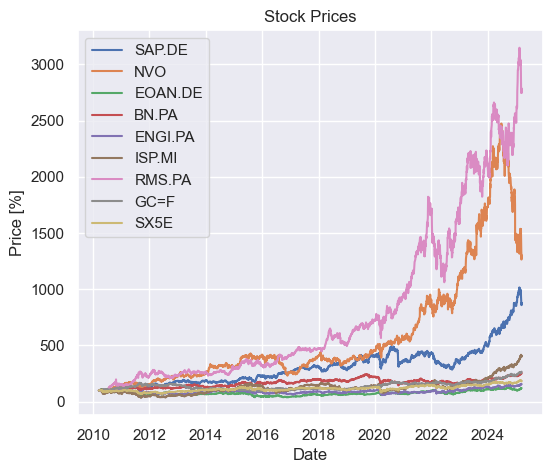

In [24]:
plt.figure(figsize=(6, 5))
plt.title("Stock Prices")
sns.lineplot(data=df.rebase(), dashes=False)
plt.ylabel("Price [%]")
plt.legend()
plt.show()

Now we can compare between the stocks their performances using the ```ffn``` library. I will add in the details section the meaning for some of the important indicators that can be used to compare the stocks.

<details>

<summary> Useful portfolio indicators </summary>

Some useful definition:

1. **CARG**:  compound annual growth rate
2. **Skew**: Measure return asymeetry
3. **Kurtosis**: High values indicate extreme results
4. **VaR** (Value at Risk): The maximum loss that can be expected with a certain probability
    1. Formula $ VaR = \mu - Z_{\alpha} \cdot \sigma $
        1. $\mu$ is mean return
        2. $Z_{\alpha}$ Z-score for confidence level (1.65 for 90%)
        3. $\sigma$ is standard deviation or volatility
5. **CVaR** (Conditional Value at Risk): The average loss that can be expected with a certain probability
6. **Sharpe Ratio**: Measure the return of an investment compared to its risk
    1. Formula $ Sharpe = \frac{R_p - R_f}{\sigma_p} $
7. **Volatility**: Measure the dispersion of returns
    1. Formula $ Volatility = \sigma = \sqrt{ \frac{\Sigma (r_t - \bar{r})^2}{n - 1} } $ 
</details>

In [25]:
df.calc_stats().display()

Stat                 SAP.DE      NVO         EOAN.DE     BN.PA       ENGI.PA     ISP.MI      RMS.PA      GC=F        SX5E
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17
End                  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         779.12%     1203.85%    20.51%      152.74%     56.02%      308.76%     2685.17%    166.41%     84.36%
Daily Sharpe         0.75        0.77        0.18        0.42        0.25        0.45        1.02        0.50        0.31
Daily Sortino        1.20        1.24        0.29        0.71        0.39        0.71        1.73        0.80        0.49
CA

We can see that most of the stocks beat the benchmark index in terms of returns and sharpe ratio, however, we can see that they are mor volatile. So, in other words, we will build a more aggresive and riskier portfolio than the benchmark. However, lucky for us we also added a commodity term in case that there are some very unstable periods.

Sometimes I get confused when to use log returns or simple returns. For this, I added the following section in case I forget.

> When to use simple returns vs log returns?
>
> - **Simple Returns**: Is for getting the actual return. Is like saying: “Today, I gained 5% on my investment.” 
> - **Log Returns**: Is like saying: “If I keep investing, how does this return accumulate over time?”
> - For statistical calculations (like correlation & covariance), log returns are the best choice because they make models more mathematically stable.

Lets check the correlation between the stocks. This is important to ckeck, because in portfolio theory, diversification mean that the variance of the portfolio converges to the average correlation of the stocks.

The variance of the portfolio is given by:

$$
\sigma_p^2 = \sum w_i^2 \sigma^2(S_i) + \sum_{i=1}^{n} \sum_{j \neq i}^{n} w_i w_j \text{cov}(i, j)
$$

If the weights are identical:

$$
\sigma_p^2 = \frac{1}{N} \sum \frac{1}{N} \sigma^2(S_i) + \frac{N-1}{N} \sum_{i=1}^{n-1} \sum_{j \neq i}^{n} \frac{1}{(N-1)(N)} \text{cov}(i, j)
$$

If we replace each term by the average:

$$
\sigma_p^2 = \frac{1}{N} \sigma_i^2 + \frac{N-1}{N} \text{cov}(i, j)
$$

Let it be:

$$
\boxed{\sigma_p^2 = \frac{1}{N} (\sigma_i^2 - \text{cov}(i, j)) + \text{cov}(i, j)}
$$

In [ ]:
log_returns = df.to_log_returns().dropna().drop('SX5E', axis=1)
log_returns.mean() * 252

SAP.DE     0.153446
NVO        0.177425
EOAN.DE    0.012536
BN.PA      0.063916
ENGI.PA    0.030534
ISP.MI     0.098408
RMS.PA     0.229296
GC=F       0.067726
dtype: float64

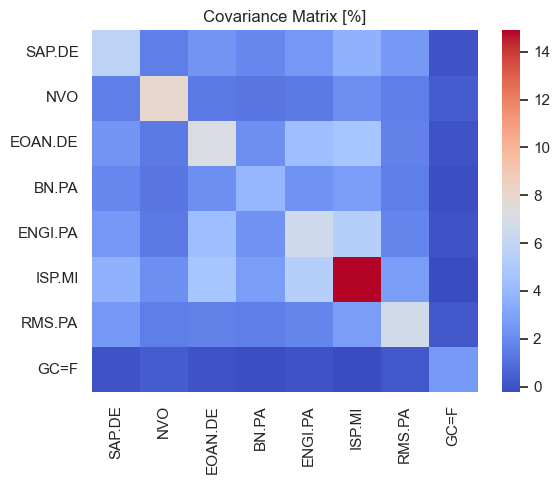

In [ ]:
plt.figure(figsize=(6, 5))
plt.title("Daily Covariance Matrix [%]")
sns.heatmap(log_returns.cov() * 252 * 100, cmap='coolwarm',
            annot=False, fmt=".2%")
plt.tight_layout()
plt.show()

It is interesting to notice that the commodity is not highly correlated with the other stocks, which is very good, in the ends it means it has a lower beta. The values are also very low, which is also very good for risk reduction.

## Static Allocation

For this section, we will use 5 historical years of data.


In [ ]:
start_date = log_returns.index[-1] - relativedelta(years=5)
last_date = log_returns.index[-1]
start_date, last_date

(Timestamp('2020-03-14 00:00:00'), Timestamp('2025-03-14 00:00:00'))

In [ ]:
log_returns = log_returns.loc[start_date:last_date]
log_returns.head(2)

,SAP.DE,NVO,EOAN.DE,BN.PA,ENGI.PA,ISP.MI,RMS.PA,GC=F
Date,,,,,,,,
2020-03-16,-0.031905,-0.075601,-0.014414,0.003713,-0.049563,-0.102619,-0.043897,-0.019857
2020-03-17,0.028554,0.048256,0.030571,0.074267,0.032247,0.034058,0.018794,0.025908


#### MC simulation

We will do a montecarlo simulation, or an exhaustive calculation to get the different return vs volatility from the portfolio.

In [ ]:
number_of_assets = len(df.drop('SX5E', axis=1).columns)
number_of_assets

8

In [ ]:
def portfolio_returns (weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

def portfolio_volatility (weights, log_returns):
    return np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

In [ ]:
Portfolio = namedtuple('Portfolio', ['returns', 'volatility'])

portfolios = [
    Portfolio(
        returns = portfolio_returns( 
                    weights := (w:= np.random.random(number_of_assets)) / np.sum(w),
                    log_returns= log_returns
        ),
        volatility = portfolio_volatility(weights, log_returns)
    )
    for _ in range(100_000)
]

df_portfolios = pd.DataFrame(portfolios)

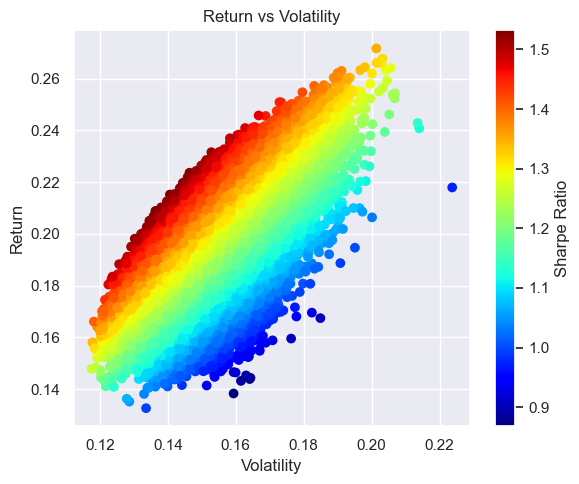

In [ ]:
plt.figure(figsize=(6, 5))
plt.title("Return vs Volatility")
plt.scatter(df_portfolios.volatility, df_portfolios.returns, 
            c=df_portfolios.returns / df_portfolios.volatility,
            cmap='jet', marker='o', alpha=1)
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.colorbar(label="Sharpe Ratio")
plt.tight_layout()
plt.show()

A little hint of how to use **scipy optimization**.


<details>
<summary>Show Scipy Optimization Code</summary>
<br>
<img src="./img/scipy-opt.jpg" alt="scipy optimization example" />
    
```python
ineq_cons = {'type': 'ineq',
             'fun' : lambda x: np.array([1 - x[0] - 2*x[1],
                                         1 - x[0]**2 - x[1],
                                         1 - x[0]**2 + x[1]]),
             'jac' : lambda x: np.array([[-1.0, -2.0],
                                          [-2*x[0], -1.0],
                                          [-2*x[0], 1.0]])}
eq_cons = {'type': 'eq',
           'fun' : lambda x: np.array([2*x[0] + x[1] - 1]),
           'jac' : lambda x: np.array([2.0, 1.0])}
```


For the bounds, we can define them as tuples with the desired range. For example, if we want to limit the weights between 0 and 1, we can define the bounds as follows:

```python
bounds = ((0, 1), (0, 1))
```

To get the optimization, we run the following code:

```python
opt_sharpe = sco.minimize(
    min_func_sharpe,
    x0=initial_guess,
    args=(returns,),
    method='SLSQP',
    bounds=bounds,
    constraints=eq_constraints
)
```

The args arguments will call the objective function as:

```min_fun_shapr(x, *args)```


</details> 


Now, we will optimize the portfolio weights by **minimizing** the **sharpe ratio**, using only 5 years of historical data.

In [ ]:
log_returns.head(1)

,SAP.DE,NVO,EOAN.DE,BN.PA,ENGI.PA,ISP.MI,RMS.PA,GC=F
Date,,,,,,,,
2020-03-16,-0.031905,-0.075601,-0.014414,0.003713,-0.049563,-0.102619,-0.043897,-0.019857


In [ ]:
def portfolio_returns (weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252
def portfolio_volatility (weights, log_returns):
    return np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

# minimization function
def min_func_sharpe(weights, log_returns):
    return -portfolio_returns(weights, log_returns) / portfolio_volatility(weights, log_returns)

# domain
bounds = tuple((0, 1) for _ in range(number_of_assets))

# CONSTRAINTS
# We want the weights to sum up to 1
eq_constraints = {
    'type': 'eq',
    'fun': lambda x: np.sum(x) - 1
} 

# An initial set of weights. Equal weights for all assets
initial_guess = number_of_assets * [1. / number_of_assets]

opt_sharpe = sco.minimize(
    min_func_sharpe,
    x0 = initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=eq_constraints,
    args=(log_returns,)
)
print("Optimal Sharpe", -1 * opt_sharpe['fun'])

Optimal Sharpe 1.5560597376298941


For the weights that are to low, we will set them to zero and renormalize the weights.

In [ ]:
x_sharpe = np.array([ value if value > 1e-7 else 0 for value in opt_sharpe.x ])
x_sharpe /= np.sum(x_sharpe)
names = df.drop('SX5E', axis=1).columns
pd.Series(x_sharpe, index=names)

SAP.DE     0.004822
NVO        0.116230
EOAN.DE    0.015813
BN.PA      0.032109
ENGI.PA    0.035573
ISP.MI     0.182713
RMS.PA     0.196976
GC=F       0.415764
dtype: float64

In [ ]:
print("Min vol returns", portfolio_returns(x_sharpe, log_returns))
print("Min vol volatility", portfolio_volatility(x_sharpe, log_returns))
print("Min vol sharpe", portfolio_returns(x_sharpe, log_returns) / portfolio_volatility(x_sharpe, log_returns))

Min vol returns 0.211900980093483
Min vol volatility 0.13617792104578136
Min vol sharpe 1.5560597376298941


We can also optimize to minimize the volatility / risk $\sigma$

In [ ]:
opt_vol = sco.minimize(
    portfolio_volatility,
    x0 = initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=eq_constraints,
    args=(log_returns,)
)

x_vol = np.array([ value if value > 1e-7 else 0 for value in opt_vol.x ])
x_vol /= np.sum(x_vol)

print("Min vol returns", portfolio_returns(x_vol, log_returns))
print("Min vol volatility", portfolio_volatility(x_vol, log_returns))
print("Min vol sharpe", portfolio_returns(x_vol, log_returns) / portfolio_volatility(x_vol, log_returns))

Min vol returns 0.1484148004417334
Min vol volatility 0.11391368236544641
Min vol sharpe 1.3028707119273344


#### Efficient Frontier

We fix the risk and we get the best return.

In [ ]:
def fun_returns (weights, log_returns):
    return -portfolio_returns(weights, log_returns)

expected_volatilities = np.linspace(0.10, 0.25, 30)
optimal_returns = []
initial_guess = number_of_assets * [1. / number_of_assets]
bounds = tuple((0, 1) for asset in range(number_of_assets))

for expected_vol in expected_volatilities:
    constraints = (
        {
            'type' : 'eq',
            'fun' : lambda x: np.sum(x) - 1
        }, {
            'type' : 'eq',
            'fun' : lambda x: portfolio_volatility(x, log_returns) - expected_vol
        }
    )
    
    opt = sco.minimize(
        fun_returns,
        x0 = initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        args=(log_returns,)
    )
    optimal_returns.append(-opt['fun'])    

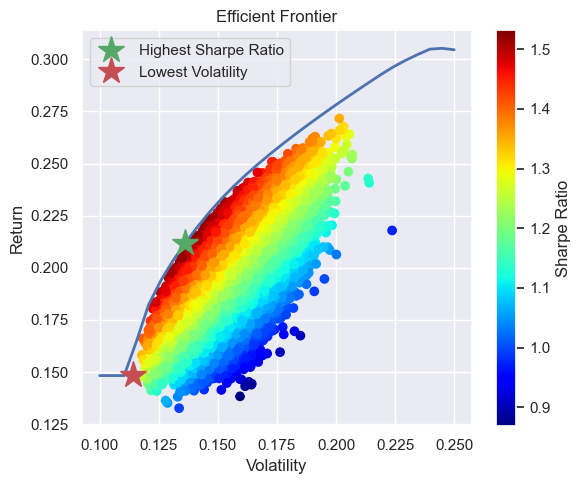

In [ ]:
plt.figure(figsize=(6, 5))
plt.title("Efficient Frontier")
plt.scatter(df_portfolios.volatility, df_portfolios.returns, 
            c=df_portfolios.returns / df_portfolios.volatility,
            cmap='jet', marker='o', alpha=1)
plt.plot(expected_volatilities, optimal_returns, lw=2)
plt.plot(portfolio_volatility(x_sharpe, log_returns), portfolio_returns(x_sharpe, log_returns), 
         'g*', markersize=20.0, label="Highest Sharpe Ratio")
plt.plot(portfolio_volatility(x_vol, log_returns), portfolio_returns(x_vol, log_returns), 
         'r*', markersize=20.0, label="Lowest Volatility")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.colorbar(label="Sharpe Ratio")
plt.tight_layout()
plt.legend()
plt.show()

Lets check the values of the benchmark

In [ ]:
log_returns_benchmark = df['SX5E'].to_log_returns().dropna().loc[start_date:last_date]
log_returns_benchmark.head(2)

Date
2020-03-16   -0.053881
2020-03-17    0.032178
Name: SX5E, dtype: float64

In [ ]:
log_returns_benchmark.std() * np.sqrt(252)

np.float64(0.1991674291006757)

In [ ]:
print("Benchmark returns", log_returns_benchmark.mean() * 252 * 100 , "%")
print("Benchmark volatility", log_returns_benchmark.std() * np.sqrt(252) * 100, "%")
print("Benchmark Sharpe", (log_returns_benchmark.mean() * 252) / (log_returns_benchmark.std() * np.sqrt(252)))

Benchmark returns 15.162227771779552 %
Benchmark volatility 19.91674291006757 %
Benchmark Sharpe 0.7612804884936938


In our portfolio, we can get a 1.5 sharpe ratio with a 13% volatility. This is a very good result, since the benchmark has a 0.7 sharpe ratio with a 20% volatility. This means that we are getting a better return with less risk.

## Dynamic Allocation & Leverage

In [145]:

class PortfolioOptimizer:
    """
    A class to perform dynamic portfolio optimization with optional leverage adjustments.
    
    Parameters
    ----------
    prices : pd.DataFrame
        Price data with a datetime index and asset columns.
    benchmark_series : pd.Series
        Benchmark performance series.
    num_periods : int, optional
        Number of portfolio rebalancing periods (default is 10).
    rebalance_period : int, optional
        Frequency of rebalancing in months (default is 6).
    history_window : int, optional
        Look-back window in months for historical data (default is 12).
    month_offset_from_today : int, optional
        Month offset from today's date to define the last month-end (default is 1).
    leverage_model : object, optional
        A classifier model used to decide whether to apply leverage. If None, no leverage is applied.
    leverage_const : float, optional
        The leverage constant to use if the model prediction is positive (default is 1.5).
    """
    
    def __init__(
        self,
        prices: pd.DataFrame,
        benchmark_series: pd.Series,
        num_periods: int = 10,
        rebalance_period: int = 6,
        history_window: int = 12,
        month_offset_from_today: int = 1,
        max_risk : float = None,
        leverage_model: Optional[Any] = None,
        leverage_const: float = 1.5
    ):
        self.prices = prices
        self.benchmark_series = benchmark_series
        self.num_periods = num_periods
        self.rebalance_period = rebalance_period
        self.history_window = history_window
        self.month_offset_from_today = max(month_offset_from_today, 1)
        self.leverage_model = leverage_model
        self.leverage_const = leverage_const
        self.max_risk = max_risk

        # Internal lists to store results during backtest
        self.optimized_weights = []
        self.portfolio_values = [1]
        self.portfolio_returns_list = []
        self.portfolio_daily_returns = []
        self.portfolio_daily_volatilities = []
        self.portfolio_daily_sharpes = []
        self.portfolio_kellys = []
        self.portfolio_vars = []
        self.portfolio_cvars = []
        self.target_volatilities = []
        self.portfolio_max_drawdowns = []
        self.portfolio_leverage_values = [1]
        self.portfolio_leverage_returns_list = []
        
        # These will be computed in run_backtest
        self.portfolio_series = None
        self.combined_series = None
        self.overall_stats = None
        self.results_df = None

    def _get_rebalancing_dates(self) -> pd.DatetimeIndex:
        """Calculate rebalancing dates based on input parameters."""
        today = pd.Timestamp.today().normalize()
        last_month_end = (today - pd.DateOffset(months=self.month_offset_from_today)
                          ).replace(day=1) + pd.offsets.MonthEnd(0)
        num_unused_periods = int(np.ceil(self.history_window / self.rebalance_period))
        total_periods = self.num_periods + num_unused_periods

        dates = pd.date_range(
            end=last_month_end,
            periods=total_periods,
            freq=pd.DateOffset(months=self.rebalance_period)
        )
        return dates[dates > (self.prices.index[0] + pd.DateOffset(months=self.history_window))]

    @staticmethod
    def _annualized_return(weights: np.ndarray, log_ret: pd.DataFrame) -> float:
        """Compute annualized portfolio return given weights and log returns."""
        return np.sum(log_ret.mean() * weights) * 252

    @staticmethod
    def _annualized_vol(weights: np.ndarray, log_ret: pd.DataFrame) -> float:
        """Compute annualized portfolio volatility given weights and log returns."""
        cov_matrix = log_ret.cov() * 252
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    def _negative_sharpe(self, weights: np.ndarray, log_ret: pd.DataFrame) -> float:
        """Objective function to minimize: negative Sharpe ratio."""
        ret = self._annualized_return(weights, log_ret)
        vol = self._annualized_vol(weights, log_ret)
        return -ret / vol

    def run_backtest(self, display_stats: bool = True, display_graph: bool = True) -> Tuple[pd.DataFrame, Dict[str, float], pd.Series]:
        """
        Run the dynamic portfolio optimization backtest with optional leverage.
        
        Parameters
        ----------
        display_stats : bool, optional
            Whether to print portfolio statistics (default is True).
        display_graph : bool, optional
            Whether to display performance graphs (default is True).
        
        Returns
        -------
        results_df : pd.DataFrame
            DataFrame containing portfolio statistics for each rebalancing period.
        overall_stats : dict
            Overall performance metrics (leveraged if leverage_model is provided).
        portfolio_series : pd.Series
            Cumulative performance series of the portfolio.
        """
        rebalancing_dates = self._get_rebalancing_dates()
        returns = self.prices.to_returns().dropna()
        log_returns = self.prices.to_log_returns().dropna()

        num_assets = len(self.prices.columns)
        bounds = tuple((0, 1) for _ in range(num_assets))
        constraints = []
        constraints.append({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        if self.max_risk is not None:
            constraints.append({'type': 'ineq', 
                                'fun': lambda w: self.max_risk - self._annualized_vol(w, log_returns)})
        initial_guess = [1. / num_assets] * num_assets

        print("Starting Dynamic Portfolio Optimization:")
        print("----------------------------------------")

        num_unused_periods = int(np.ceil(self.history_window / self.rebalance_period))
        for period in range(num_unused_periods, len(rebalancing_dates) - 1):
            # Define historical window
            start_date = rebalancing_dates[period] - relativedelta(months=self.history_window)
            end_date = rebalancing_dates[period]
            historical_log_returns = log_returns.loc[start_date:end_date]
            historical_returns = returns.loc[start_date:end_date]
                

            # Optimize weights using SLSQP
            opt_result = sco.minimize(
                self._negative_sharpe,
                x0=initial_guess,
                args=(historical_log_returns,),
                method='SLSQP',
                bounds=bounds,
                constraints=constraints
            )
            weights = np.array([w if w > 1e-7 else 0 for w in opt_result.x])
            weights /= np.sum(weights)
            self.optimized_weights.append(weights)

            # Get future returns for next period
            next_period_start = end_date + pd.DateOffset(days=1)
            next_period_end = end_date + pd.DateOffset(months=self.rebalance_period)
            future_returns = returns.loc[next_period_start:next_period_end]
            period_portfolio_returns = future_returns.dot(weights)

            # Store portfolio value change (%)
            period_value_change = (1 + period_portfolio_returns).cumprod().iloc[-1] - 1
            self.portfolio_values.append(round(period_value_change * 100, 2))
            self.portfolio_returns_list.append(period_portfolio_returns)

            # Calculate stats using historical performance
            hist_portfolio_series = (1 + historical_returns.dot(weights)).cumprod() * 100
            port_stats = hist_portfolio_series.calc_stats()
            daily_return = port_stats.stats.get('daily_mean')
            daily_vol = port_stats.stats.get('daily_vol')
            daily_sharpe = port_stats.stats.get('daily_sharpe')
            max_drawdown = port_stats.stats.get('max_drawdown')

            kelly = daily_return / (daily_vol ** 2)
            target_vol = 0.15
            dynamic_target_leverage = np.clip(target_vol / daily_vol, 0.5, 3)
            var_value = period_portfolio_returns.quantile(0.05)
            cvar_value = period_portfolio_returns[period_portfolio_returns < var_value].mean()

            # Save period stats
            self.portfolio_daily_returns.append(round(daily_return * 100, 2))
            self.portfolio_daily_volatilities.append(round(daily_vol * 100, 2))
            self.portfolio_daily_sharpes.append(round(daily_sharpe, 2))
            self.portfolio_kellys.append(kelly)
            self.portfolio_vars.append(var_value)
            self.portfolio_cvars.append(cvar_value)
            self.target_volatilities.append(dynamic_target_leverage)
            self.portfolio_max_drawdowns.append(max_drawdown)

            # Leverage adjustment if a model is provided
            
            
            if self.leverage_model is not None:
                leverage_input = pd.DataFrame({
                    "Portfolio Daily Return (%)": [self.portfolio_daily_returns[-1]],
                    "Portfolio Daily Volatility (%)": [self.portfolio_daily_volatilities[-1]],
                    "Portfolio Daily Sharpe": [self.portfolio_daily_sharpes[-1]],
                    "Portfolio Kelly": [self.portfolio_kellys[-1]],
                    "Portfolio VaR": [self.portfolio_vars[-1]],
                    "Portfolio CVaR": [self.portfolio_cvars[-1]],
                    "Target Volatility": [self.target_volatilities[-1]],
                    "Max Drawdown": [self.portfolio_max_drawdowns[-1]]
                })
                leverage_prediction = self.leverage_model.predict(leverage_input)
                dynamic_leverage = self.leverage_const if leverage_prediction[0] == 1 else 1

                period_leveraged_returns = period_portfolio_returns * dynamic_leverage
                leveraged_value_change = (1 + period_leveraged_returns).cumprod().iloc[-1] - 1
                self.portfolio_leverage_values.append(round(leveraged_value_change * 100, 2))
                self.portfolio_leverage_returns_list.append(period_leveraged_returns)
            else:
                dynamic_leverage = 1

        # Combine portfolio series
        portfolio_return_series = pd.concat(self.portfolio_returns_list)
        self.portfolio_series = 100 * (1 + portfolio_return_series).cumprod()

        self.combined_series = pd.concat([self.portfolio_series, self.benchmark_series], axis=1)
        self.combined_series.columns = ['Portfolio', 'Benchmark']
        self.combined_series.dropna(inplace=True)

        if self.leverage_model is not None and self.portfolio_leverage_returns_list:
            portfolio_leverage_series = 100 * (1 + pd.concat(self.portfolio_leverage_returns_list)).cumprod()
            self.combined_series = pd.concat([self.combined_series, portfolio_leverage_series], axis=1)
            self.combined_series.columns = ['Portfolio', 'Benchmark', 'Portfolio Leverage']

        # Calculate overall statistics.
        portfolio_stats = self.combined_series['Portfolio'].calc_stats().stats
        benchmark_stats = self.combined_series['Benchmark'].calc_stats().stats
        if 'Portfolio Leverage' in self.combined_series.columns:
            leverage_stats = self.combined_series['Portfolio Leverage'].calc_stats().stats
        else:
            leverage_stats = None

        # Choose overall stats based on whether leverage was applied.
        if leverage_stats is not None:
            total_return = leverage_stats.get('total_return')
            yearly_return = leverage_stats.get('yearly_mean')
            yearly_vol = leverage_stats.get('yearly_vol')
            yearly_sharpe = leverage_stats.get('yearly_sharpe')
            cagr = leverage_stats.get('cagr')
            max_dd = leverage_stats.get('max_drawdown')
        else:
            total_return = portfolio_stats.get('total_return')
            yearly_return = portfolio_stats.get('yearly_mean')
            yearly_vol = portfolio_stats.get('yearly_vol')
            yearly_sharpe = portfolio_stats.get('yearly_sharpe')
            cagr = portfolio_stats.get('cagr')
            max_dd = portfolio_stats.get('max_drawdown')

        self.overall_stats = {
            "Total Return": total_return,
            "Yearly Return": yearly_return,
            "Yearly Volatility": yearly_vol,
            "Yearly Sharpe": yearly_sharpe,
            "CAGR": cagr,
            "Max Drawdown": max_dd
        }

        if display_stats:
            init_date = portfolio_stats.get('start').date().strftime("%Y-%m-%d")
            end_date_str = portfolio_stats.get('end').date().strftime("%Y-%m-%d")
            print("Portfolio Stats:")
            print(f"Init date: {init_date} | End date: {end_date_str}\n")
            if leverage_stats is not None:
                print(f"\t           | Portfolio\t | Benchmark\t | Leverage Portfolio")
                print("-" * 90)
                print(f"Total Return:\t   | {portfolio_stats.get('total_return')*100:2.2f}%\t | {benchmark_stats.get('total_return')*100:2.2f}%\t | {total_return*100:2.2f}%")
                print(f"Yearly Return:\t   | {portfolio_stats.get('yearly_mean')*100:2.2f}%\t | {benchmark_stats.get('yearly_mean')*100:2.2f}%\t | {yearly_return*100:2.2f}%")
                print(f"Yearly Volatility: | {portfolio_stats.get('yearly_vol')*100:2.2f}%\t | {benchmark_stats.get('yearly_vol')*100:2.2f}%\t | {yearly_vol*100:2.2f}%")
                print(f"Yearly Sharpe:\t   | {portfolio_stats.get('yearly_sharpe'):2.2f}\t | {benchmark_stats.get('yearly_sharpe'):2.2f}\t\t | {yearly_sharpe:2.2f}")
                print(f"CAGR:\t\t   | {portfolio_stats.get('cagr')*100:2.2f}%\t | {benchmark_stats.get('cagr')*100:2.2f}%\t | {cagr*100:2.2f}%")
                print(f"Max Drawdown:\t   | {portfolio_stats.get('max_drawdown')*100:2.2f}%\t | {benchmark_stats.get('max_drawdown')*100:2.2f}%\t | {max_dd*100:2.2f}%")
            else:
                print(f"\t          | Portfolio\t | Benchmark")
                print("-" * 70)
                print(f"Total Return:\t   | {portfolio_stats.get('total_return')*100:2.2f}% \t | {benchmark_stats.get('total_return')*100:2.2f}%")
                print(f"Yearly Return:\t   | {portfolio_stats.get('yearly_mean')*100:2.2f}% \t | {benchmark_stats.get('yearly_mean')*100:2.2f}%")
                print(f"Yearly Volatility: | {portfolio_stats.get('yearly_vol')*100:2.2f}% \t | {benchmark_stats.get('yearly_vol')*100:2.2f}%")
                print(f"Yearly Sharpe:\t   | {portfolio_stats.get('yearly_sharpe'):2.2f}\t | {benchmark_stats.get('yearly_sharpe'):2.2f}")
                print(f"CAGR:\t\t   | {portfolio_stats.get('cagr')*100:2.2f}% \t | {benchmark_stats.get('cagr')*100:2.2f}%")
                print(f"Max Drawdown:\t   | {portfolio_stats.get('max_drawdown')*100:2.2f}% \t | {benchmark_stats.get('max_drawdown')*100:2.2f}%")
        
        if display_graph:
            plt.figure(figsize=(6, 4))
            plt.title("Portfolio Performance")
            sns.lineplot(data=self.combined_series.rebase())
            plt.ylabel("Portfolio Value")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        # Build a DataFrame with period statistics.
        self.results_df = pd.DataFrame({
            "Date": rebalancing_dates[num_unused_periods:-1],
            "Portfolio Value (%)": self.portfolio_values[1:],
            "Portfolio Daily Return (%)": self.portfolio_daily_returns,
            "Portfolio Daily Volatility (%)": self.portfolio_daily_volatilities,
            "Portfolio Daily Sharpe": self.portfolio_daily_sharpes,
            "Portfolio Kelly": self.portfolio_kellys,
            "Portfolio VaR": self.portfolio_vars,
            "Portfolio CVaR": self.portfolio_cvars,
            "Target Volatility": self.target_volatilities,
            "Max Drawdown": self.portfolio_max_drawdowns,
            # Uncomment the next line to include asset weights for each period.
            # **{f"Weights_{col}": [w[i] for w in self.optimized_weights] for i, col in enumerate(self.prices.columns)}
        })
        
        return self.results_df, self.overall_stats, self.portfolio_series


### 1. Dynamic Portfolio Allocation

- **Objective:**  
  The goal is to allocate the portfolio dynamically over a series of periods (defined by `num_periods`). For each period, you use a fixed amount of historical data (`history_window` months) to compute optimal asset weights. These weights are then applied for the next period (`rebalance_period` months).

- **Backtesting Framework:**  
  Since this is used as a backtesting methodology, it is important to simulate historical performance accurately. The backtest considers:
  - **End Date:** Determined by `month_offset_from_today`, which sets how far in the past the "end date" of the allocation should be.
  - **Historical Data Requirement:** Ensures that each allocation period has at least `history_window` months of data to compute returns and optimal weights.

---

### 2. Handling Dates

- **Rebalancing Dates:**  
  - **Last Month-End:**  
    The code calculates the **last month-end** relative to today, adjusted by `month_offset_from_today` months.
  - **Generating Dates:**  
    It then generates a series of rebalancing dates (spaced by `rebalance_period` months) moving backward from that last month-end.
  - **History Window Constraint:**  
    The first rebalancing date is selected such that there is a complete `history_window` of data available before it. This is critical for the first iteration of the backtest.

---

### 3. Portfolio Weight Optimization

- **Historical Window & Weights Calculation:**  
  For each rebalancing date:
  - The code takes the previous `history_window` months of data.
  - It computes returns (both simple and logarithmic) and uses an optimization routine (SLSQP) to determine the asset weights that maximize the portfolio's Sharpe ratio (minimizing the negative Sharpe ratio).
  - The computed weights are then applied to the returns of the next `rebalance_period` months to obtain the portfolio's return series.

- **Performance Metrics:**  
  Using the portfolio return series, libraries such as `ffn` can be used to compute key performance metrics:
  - **Sharpe Ratio**
  - **Volatility**
  - **CAGR (Compounded Annual Growth Rate)**
  - **Maximum Drawdown**

---

### 4. Leverage Strategy Preview

- **Concept of Leverage:**  
  After calculating the optimal weights and simulating the portfolio returns, a leverage strategy is applied. This involves borrowing money (at 0% interest in this case) to amplify the portfolio returns. However, leveraging also increases risk.

- **Using XGBoost for Prediction:**  
  - **Feature Extraction:**  
    The model uses various risk and performance metrics as features:
    - Volatility targeting value (target volatility divided by historical volatility)
    - Value at Risk (VaR)
    - Conditional Value at Risk (CVaR)
    - Kelly Criterion, etc.
    
    These metrics are collected into a DataFrame (`results_df`) which represents historical performance characteristics.
  
  - **Classification Problem:**  
    A classification model (using XGBoost) is set up where:
    - **1** indicates expected positive returns.
    - **0** indicates expected negative returns.
    
    The classifier uses the historical metrics as features to predict whether to apply leverage. If the model predicts a positive outcome (1), a leverage factor (e.g., 1.5×) is applied to the upcoming period's returns; otherwise, no leverage is applied.

---

### 5. Summary

- **Dates & Historical Data:**  
  Managing dates correctly is challenging yet crucial. The process ensures that every rebalancing period starts only after accumulating a complete `history_window` of data and that the portfolio performance is tracked meaningfully from the chosen start date until the backtest end date.

- **Portfolio Calculation:**  
  The process involves dynamic rebalancing by:
  1. Computing optimal asset weights using historical data.
  2. Applying these weights to calculate future returns.
  3. Constructing a time series that is used to compute performance metrics via the `ffn` library.

- **Leverage with Prediction:**  
  The approach uses performance metrics from historical optimal weights to build features for an XGBoost classifier. This classifier predicts whether to apply leverage in the upcoming period (to borrow money at 0% interest), potentially amplifying returns when conditions are favorable.

This layered methodology—starting with dynamic portfolio optimization and adding a predictive leverage component—creates a robust and flexible framework for backtesting and evaluating portfolio strategies.

Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2020-08-31 | End date: 2025-02-28

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 163.64% 	 | 66.95%
Yearly Return:	   | 25.61% 	 | 9.55%
Yearly Volatility: | 28.94% 	 | 13.09%
Yearly Sharpe:	   | 0.88	 | 0.73
CAGR:		   | 24.07% 	 | 12.08%
Max Drawdown:	   | -35.79% 	 | -25.50%


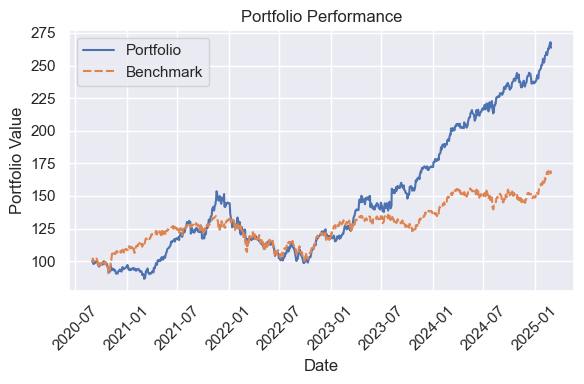

In [ ]:
dynamic_optimizer = PortfolioOptimizer(
    prices = df.drop('SX5E', axis=1),
    benchmark_series = df['SX5E'],
    num_periods = 10,
    rebalance_period = 6,
    history_window = 12,
    month_offset_from_today = 1
)

results_df, overall_stats, portfolio_series = dynamic_optimizer.run_backtest(
    display_stats=True, 
    display_graph=True
)

We can see that the portfolio outperforms the benchmark in returns and in sharpe ratio. Yet, it has more volatility and higher max drawdown.

In [ ]:
results_df.head()

,Date,Portfolio Value (%),Portfolio Daily Return (%),Portfolio Daily Volatility (%),Portfolio Daily Sharpe,Portfolio Kelly,Portfolio VaR,Portfolio CVaR,Target Volatility,Max Drawdown
0,2020-08-28,-10.64,28.71,17.01,1.69,9.922296,-0.016019,-0.023646,0.881810,-0.162505
1,2021-02-28,36.72,41.60,26.92,1.55,5.740362,-0.016088,-0.024875,0.557223,-0.194067
2,2021-08-28,1.58,53.74,16.36,3.29,20.087233,-0.028163,-0.036710,0.917109,-0.061985
3,2022-02-28,-13.79,34.67,12.57,2.76,21.934483,-0.024228,-0.029977,1.193149,-0.065760
4,2022-08-28,16.24,16.38,23.89,0.69,2.870943,-0.017594,-0.025660,0.627945,-0.221352


Now, i will get more data to build a classification model that can predict the sign of the future value given the historical data leverage indicators. This will be used to say when to leverage the portfolio. If the future portfolio sign is positive, then we leverage.

For this, I will use all the historical data to build the dataset.

Month lag: 1
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-08-29 | End date: 2025-02-28

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 274.87% 	 | 124.45%
Yearly Return:	   | 11.99% 	 | 6.49%
Yearly Volatility: | 22.66% 	 | 12.51%
Yearly Sharpe:	   | 0.53	 | 0.52
CAGR:		   | 11.15% 	 | 6.68%
Max Drawdown:	   | -35.79% 	 | -38.27%


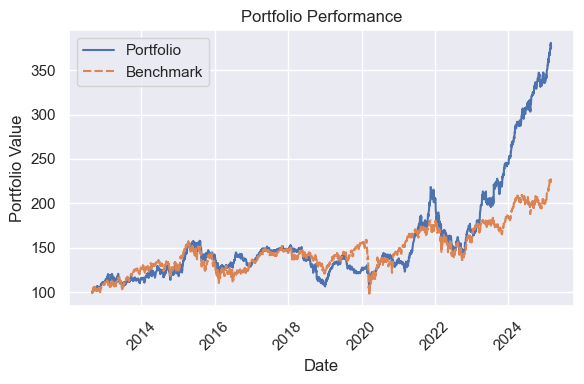

Month lag: 2
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-08-02 | End date: 2025-01-31

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 234.22% 	 | 133.59%
Yearly Return:	   | 9.87% 	 | 6.21%
Yearly Volatility: | 16.31% 	 | 12.41%
Yearly Sharpe:	   | 0.61	 | 0.50
CAGR:		   | 10.14% 	 | 7.02%
Max Drawdown:	   | -39.76% 	 | -38.27%


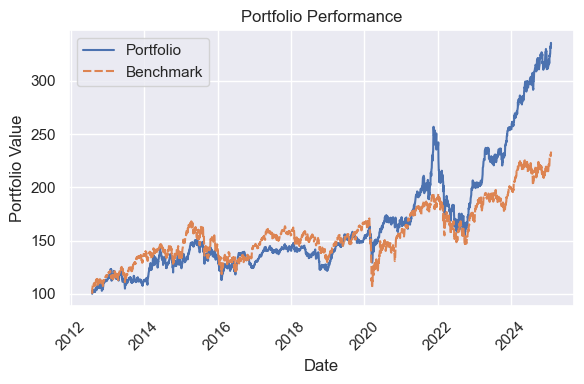

Month lag: 3
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-07-02 | End date: 2024-12-30

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 276.77% 	 | 112.44%
Yearly Return:	   | 12.47% 	 | 6.01%
Yearly Volatility: | 18.19% 	 | 12.94%
Yearly Sharpe:	   | 0.69	 | 0.46
CAGR:		   | 11.20% 	 | 6.22%
Max Drawdown:	   | -36.97% 	 | -38.27%


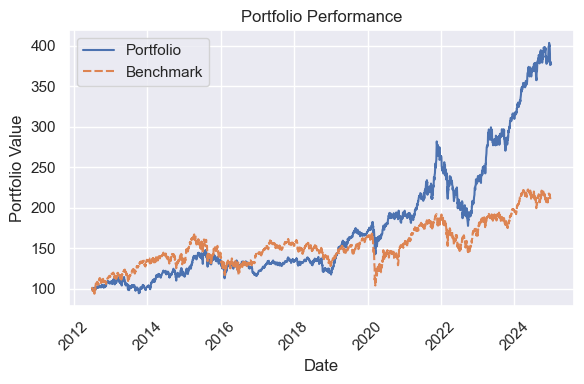

Month lag: 4
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-05-31 | End date: 2024-11-29

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 354.66% 	 | 126.74%
Yearly Return:	   | 15.23% 	 | 5.89%
Yearly Volatility: | 15.36% 	 | 12.93%
Yearly Sharpe:	   | 0.99	 | 0.46
CAGR:		   | 12.88% 	 | 6.77%
Max Drawdown:	   | -30.59% 	 | -38.27%


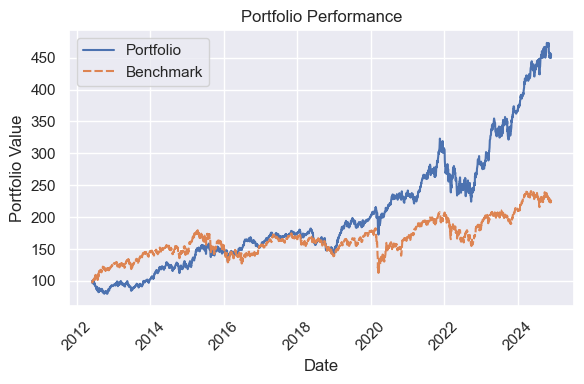

Month lag: 5
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-05-02 | End date: 2024-10-30

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 192.37% 	 | 113.32%
Yearly Return:	   | 12.78% 	 | 6.04%
Yearly Volatility: | 18.36% 	 | 12.94%
Yearly Sharpe:	   | 0.70	 | 0.47
CAGR:		   | 8.97% 	 | 6.25%
Max Drawdown:	   | -26.69% 	 | -38.27%


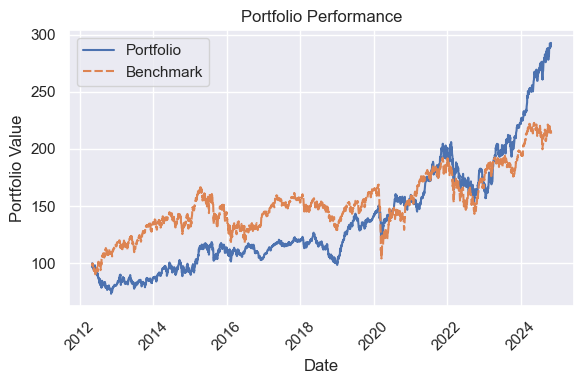

Month lag: 6
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-04-02 | End date: 2024-09-30

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 227.22% 	 | 99.92%
Yearly Return:	   | 11.99% 	 | 6.25%
Yearly Volatility: | 18.78% 	 | 13.00%
Yearly Sharpe:	   | 0.64	 | 0.48
CAGR:		   | 9.95% 	 | 5.70%
Max Drawdown:	   | -27.89% 	 | -38.27%


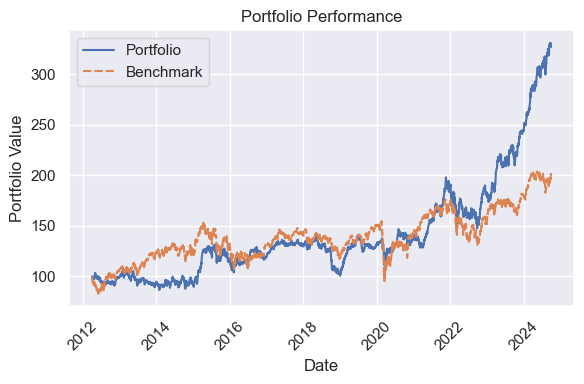

In [ ]:
list_results = []

for month_lag in range(1, 7):
    print(f"Month lag: {month_lag}")
    dynamic_optimizer = PortfolioOptimizer(
        prices = df.drop('SX5E', axis=1),
        benchmark_series = df['SX5E'],
        num_periods = 100,
        rebalance_period = 6,
        history_window = 12,
        month_offset_from_today = month_lag
    )

    results_df, overall_stats, portfolio_series = dynamic_optimizer.run_backtest(
        display_stats=True, 
        display_graph=True
    )
    results_df['Month_lag'] = month_lag
    list_results.append(results_df)
    
df_results = pd.concat(list_results)

In [ ]:
df_results.shape

(150, 11)

In [ ]:
df_results.head()

,Date,Portfolio Value (%),Portfolio Daily Return (%),Portfolio Daily Volatility (%),Portfolio Daily Sharpe,Portfolio Kelly,Portfolio VaR,Portfolio CVaR,Target Volatility,Max Drawdown,Month_lag
0,2012-08-28,14.60,43.16,21.18,2.04,9.625713,-0.015177,-0.032765,0.708370,-0.132794,1
1,2013-02-28,-2.71,23.06,18.57,1.24,6.688019,-0.018675,-0.021394,0.807836,-0.139151,1
2,2013-08-28,7.51,16.95,15.02,1.13,7.514453,-0.011402,-0.013901,0.998783,-0.116503,1
3,2014-02-28,1.67,48.90,18.14,2.70,14.861015,-0.019043,-0.023349,0.826930,-0.129980,1
4,2014-08-28,13.70,36.09,16.18,2.23,13.786848,-0.024259,-0.027419,0.927114,-0.086799,1


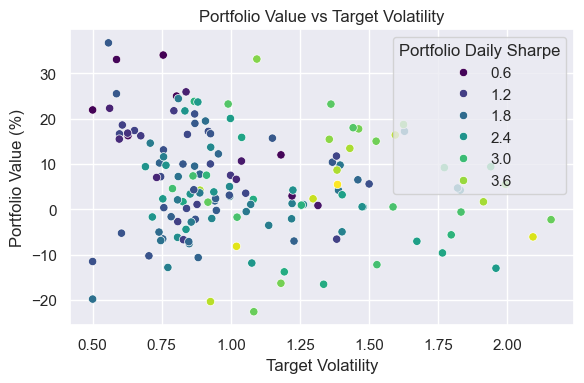

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_results, x='Target Volatility', y='Portfolio Value (%)',
                hue='Portfolio Daily Sharpe', palette='viridis')
plt.title("Portfolio Value vs Target Volatility")
plt.tight_layout()

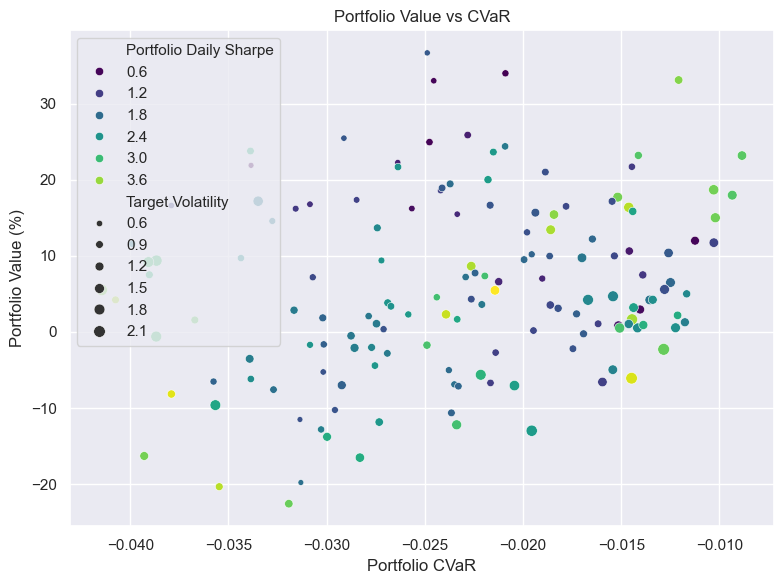

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_results,
                x = 'Portfolio CVaR', y="Portfolio Value (%)",
                size = 'Target Volatility', hue='Portfolio Daily Sharpe', palette='viridis')
plt.title("Portfolio Value vs CVaR")
plt.tight_layout()

We can see that there are some correlations between the positive future values and the features given by the past values of the portfolio. Specially, the CVaR, there is a little trend in the data.

Lets define the predicting vector. I want to be pretty sure that the returns are positive. So I will use a 0.5 threshold for defining positiviness.

In [ ]:
df_results['leverage'] = ( df_results['Portfolio Value (%)'] > 0.5 ).astype(int)
df_results.tail()

,Date,Portfolio Value (%),Portfolio Daily Return (%),Portfolio Daily Volatility (%),Portfolio Daily Sharpe,Portfolio Kelly,Portfolio VaR,Portfolio CVaR,Target Volatility,Max Drawdown,Month_lag,leverage
20,2022-03-30,-11.85,34.20,13.94,2.45,17.588314,-0.019282,-0.027321,1.075709,-0.097593,6,0
21,2022-09-30,33.05,15.27,25.58,0.60,2.334351,-0.016893,-0.024544,0.586440,-0.235493,6,1
22,2023-03-30,7.23,35.35,18.53,1.91,10.297444,-0.012963,-0.022921,0.809619,-0.118200,6,1
23,2023-09-30,33.15,47.66,13.71,3.48,25.347091,-0.008875,-0.012076,1.093913,-0.052470,6,1
24,2024-03-30,13.45,38.72,10.49,3.69,35.203752,-0.009710,-0.018592,1.430281,-0.061231,6,1


In [ ]:
df_results['leverage'].value_counts()

leverage
1    105
0     45
Name: count, dtype: int64

Best parameters: OrderedDict({'alpha': 0, 'colsample_bytree': 0.9624834391230959, 'gamma': 0.17255881941278864, 'lambda': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 480, 'scale_pos_weight': 7, 'subsample': 0.9282628845304102})
Best score: 0.7820512820512819
Accuracy: 0.6
F1 Score: 0.7272727272727273
Confusion Matrix:
[[ 3 16]
 [ 2 24]]


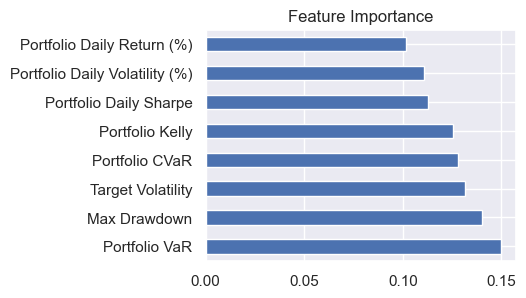

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_results.drop(columns=['Portfolio Value (%)', 'Date', 'Month_lag', 'leverage']),
    df_results['leverage'],
    test_size=0.3,
    random_state=42
)

param_grid = {
    'n_estimators': (400, 600),
    'learning_rate': (0.01, 0.07),
    'max_depth': (1, 7),
    'min_child_weight': (1, 5),
    'gamma': (0, 0.5),
    'subsample': (0.8, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'lambda': (0, 2),
    'alpha': (0, 1),
    'scale_pos_weight' : (1, 10),
}


bayes_search = BayesSearchCV(
    xgb.XGBClassifier(),
    param_grid,
    n_iter=32,
    cv=4,
    n_jobs=-1,
    verbose=0
)
bayes_search.fit(X_train, y_train)
best_clf = bayes_search.best_estimator_
print("Best parameters:", bayes_search.best_params_)
print("Best score:", bayes_search.best_score_)

y_pred = best_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# feature importance
plt.figure(figsize=(4, 3))
feature_importance = pd.Series(best_clf.feature_importances_, index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

We will try to see if this can improve the portfolio perfomance by leveraging.

Month lag: 1
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 2
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 3
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 4
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 5
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 6
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 1
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 2
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 3
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 4
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 5
Starting Dynamic Portfolio Optimizati

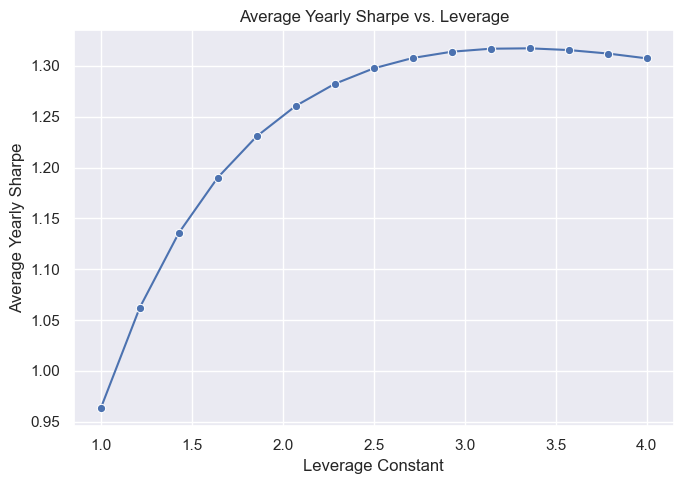

In [ ]:
leverages_results = []
for leverage in np.linspace(1, 4, 15):
    period_sharpes = []
    for month_lag in range(1, 7):
        print(f"Month lag: {month_lag}")

        dynamic_optimizer = PortfolioOptimizer(
            prices = df.drop('SX5E', axis=1),
            benchmark_series = df['SX5E'],
            num_periods = 10,
            rebalance_period = 6,
            history_window = 12,
            month_offset_from_today = month_lag,
            leverage_const=leverage,
            leverage_model=best_clf
        )
        _, end_stats, _ = dynamic_optimizer.run_backtest(display_stats=False, display_graph=False)
        
        period_sharpes.append(end_stats["Yearly Sharpe"])
    leverages_results.append({
        'avg_sharpe': np.mean(period_sharpes),
        'leverage': leverage
    })

df_leverage_results = pd.DataFrame(leverages_results)
sns.lineplot(data=df_leverage_results, x="leverage", y="avg_sharpe", marker="o")
plt.title("Average Yearly Sharpe vs. Leverage")
plt.xlabel("Leverage Constant")
plt.ylabel("Average Yearly Sharpe")
plt.tight_layout()
plt.show()

Looking at this graph, there is a clear maximum for the average volatility. For the sake of this code only, i will tike the value 2.5 as the leverage, since from this point onwrads, the function is decreasing substantially.

Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2020-08-31 | End date: 2025-02-28

	           | Portfolio	 | Benchmark	 | Leverage Portfolio
------------------------------------------------------------------------------------------
Total Return:	   | 163.64%	 | 66.95%	 | 1009.76%
Yearly Return:	   | 25.61%	 | 9.55%	 | 84.06%
Yearly Volatility: | 28.94%	 | 13.09%	 | 80.28%
Yearly Sharpe:	   | 0.88	 | 0.73		 | 1.05
CAGR:		   | 24.07%	 | 12.08%	 | 70.81%
Max Drawdown:	   | -35.79%	 | -25.50%	 | -60.91%


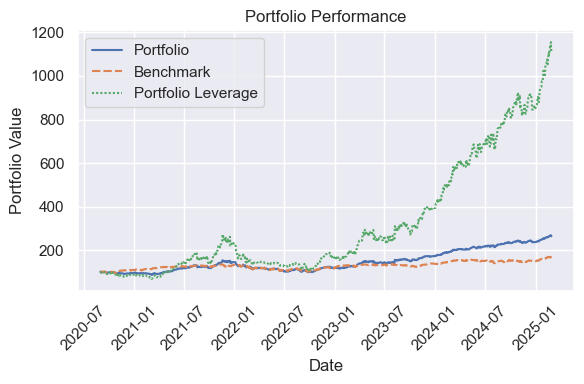

In [ ]:
dynamic_optimizer = PortfolioOptimizer(
        prices = df.drop('SX5E', axis=1),
        benchmark_series = df['SX5E'],
        num_periods = 10,
        rebalance_period = 6,
        history_window = 12,
        month_offset_from_today = 1,
        leverage_const=2.5,
        leverage_model=best_clf
    )

_, end_stats, _ = dynamic_optimizer.run_backtest(display_stats=True, display_graph=True)

we can see that the portfolio without leverage still beats the benchmark. However, the portfolio with leverage beats the benchmark by a lot. However, we need to be carefull, since the volatility / risk is also increasing. This is a very risky strategy. For implementation, I would add a risk control for the leverage, to diminish the max drawdown and the risk.

# Patrimonial Portfolio

## Investment Universe & Selection

Im looking for stable stocks, bonds, money currency and commodities. I will use the following stocks:

In [75]:
patrimonial_portfolio = {
    "Equities Defensive": ["SAN.PA", "NOVN.SW", "NG.L", "ISP.MI"],
    "Equities Defensive 2" : ["ENEL.MI", "ORSTED.CO", "NG.L", "HSBA.L" ],
    "Fixed Income euro": ["IBGL.L", "IBGL.L", "EUN3.DE"],
    "Fixed Income Corporate" : ["IBGS.L", "IEAC.L", "LQDE.L"],
    "Fixed Income inflation" : ["IBCI.L", "EMI.MI"],
    "Commodities (Gold)": ["GC=F"],
    "Commodities (Copper)" : ["HG=F"],
    "Currency ETFs / Pairs": ["UUP", "EURUSD=X", "EURCHF=X", "EURGBP=X", "EURJPY=X"],
}

In [76]:
best_sharpe_stocks = find_best_sharpe_per_industry(patrimonial_portfolio)

c:\Users\Marti\anaconda3\envs\portfolioEnv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Marti\anaconda3\envs\portfolioEnv\lib\site-packages\ffn\core.py:1358: RuntimeWarning: invalid value encountered in scalar power
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1
c:\Users\Marti\anaconda3\envs\portfolioEnv\lib\site-packages\ffn\core.py:1358: RuntimeWarning: invalid value encountered in scalar power
  return (prices.iloc[-1] / prices.iloc[0]) ** (1 / year_frac(start, end)) - 1


In [77]:
df_best_tickers_per_industry = pd.DataFrame.from_dict(best_sharpe_stocks, orient='index', columns=['Best Ticker', 'Monthly Sharpe'])
best_tickers = df_best_tickers_per_industry['Best Ticker'].values
df_best_tickers_per_industry

,Best Ticker,Monthly Sharpe
Equities Defensive,ISP.MI,1.143536
Equities Defensive 2,HSBA.L,0.685370
Fixed Income euro,EUN3.DE,-0.561525
Fixed Income Corporate,IEAC.L,0.180848
Fixed Income inflation,EMI.MI,0.299362
Commodities (Gold),GC=F,0.980545
Commodities (Copper),HG=F,0.859207
Currency ETFs / Pairs,EURJPY=X,0.814243


Now i get their historical time series.

In [78]:
df = pd.DataFrame()

for ticker in best_tickers:
    data = yf.Ticker(ticker).history(period="15y")['Close'].dropna()
    data.index = data.index.normalize().tz_localize(None)
    df[ticker] = data
df = df.dropna()
df.head()

,ISP.MI,HSBA.L,EUN3.DE,IEAC.L,EMI.MI,GC=F,HG=F,EURJPY=X
Date,,,,,,,,
2010-03-17,1.174419,642.908203,67.886612,93.870476,116.811989,1124.000000,3.4100,124.184998
2010-03-18,1.172403,631.958008,68.285789,93.894714,116.552208,1127.400024,3.3875,123.160004
2010-03-19,1.144176,631.030151,68.450684,93.910873,116.392342,1107.400024,3.3645,122.519997
2010-03-22,1.130064,629.266541,68.528786,94.023979,116.352379,1099.300049,3.3725,122.550003
2010-03-23,1.120991,627.132385,68.685005,94.056282,116.841957,1103.500000,3.3695,121.680000


### Benchmark of patrimonial portfolio

In [79]:
df_benchmark = pd.read_csv(
    os.path.join("data", "historical_price_FR0010135103.csv")
)
df_benchmark['NavDate'] = pd.to_datetime(df_benchmark['NavDate'], format="%d/%m/%Y")
df_benchmark.set_index('NavDate', inplace=True)
df_benchmark.head()

,FundName,ISIN,NavValue (in €),IndexValue (in €),DividendValue (in €)
NavDate,,,,,
1989-11-07,Carmignac Patrimoine,FR0010135103,76.55,99.38,NaN
1989-11-08,Carmignac Patrimoine,FR0010135103,76.58,99.69,NaN
1989-11-10,Carmignac Patrimoine,FR0010135103,76.64,100.35,NaN
1989-11-13,Carmignac Patrimoine,FR0010135103,76.66,100.32,NaN
1989-11-14,Carmignac Patrimoine,FR0010135103,76.68,99.99,NaN


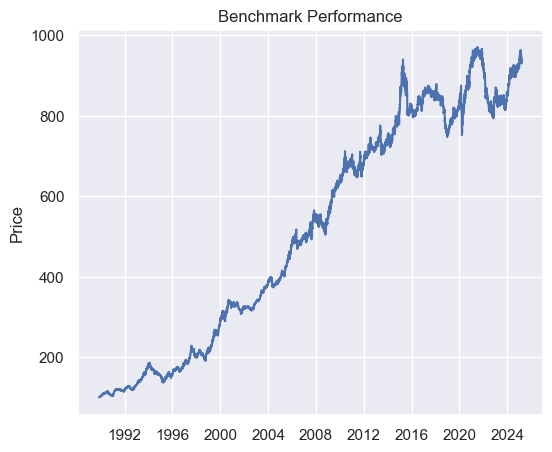

In [80]:
plt.figure(figsize = (6,5))
plt.plot(df_benchmark['NavValue (in €)'].rebase())
plt.title("Benchmark Performance")
plt.ylabel("Price")
plt.show()

In [81]:
df_benchmark.rename(columns={'NavValue (in €)': 'Bench'}, inplace=True)
df_benchmark = df_benchmark[['Bench']]
df_benchmark.head()

,Bench
NavDate,
1989-11-07,76.55
1989-11-08,76.58
1989-11-10,76.64
1989-11-13,76.66
1989-11-14,76.68


In [ ]:
df = pd.concat([df, df_benchmark], axis=1).dropna()
df.head()

,ISP.MI,HSBA.L,EUN3.DE,IEAC.L,EMI.MI,GC=F,HG=F,EURJPY=X,Bench
2010-03-17,1.174419,642.908203,67.886612,93.870476,116.811989,1124.000000,3.4100,124.184998,498.81
2010-03-18,1.172403,631.958008,68.285789,93.894714,116.552208,1127.400024,3.3875,123.160004,500.26
2010-03-19,1.144176,631.030151,68.450684,93.910873,116.392342,1107.400024,3.3645,122.519997,500.29
2010-03-22,1.130064,629.266541,68.528786,94.023979,116.352379,1099.300049,3.3725,122.550003,499.96
2010-03-23,1.120991,627.132385,68.685005,94.056282,116.841957,1103.500000,3.3695,121.680000,500.91
...,...,...,...,...,...,...,...,...,...
2025-03-10,4.790000,854.799988,82.330002,119.160004,162.949997,2891.000000,4.6395,160.302994,713.24
2025-03-11,4.689000,841.599976,81.709999,118.849998,163.240005,2912.899902,4.7400,159.399994,711.47
2025-03-12,4.769000,847.700012,81.629997,118.830002,164.050003,2939.100098,4.8210,161.563995,714.13
2025-03-13,4.719000,853.099976,82.014000,118.559998,162.860001,2984.300049,4.8985,161.406998,713.93


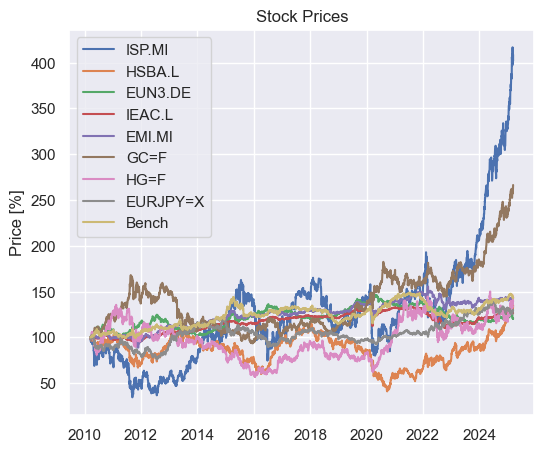

In [83]:
plt.figure(figsize=(6, 5))
plt.title("Stock Prices")
sns.lineplot(data=df.rebase(), dashes=False)
plt.ylabel("Price [%]")
plt.legend()
plt.show()

In [84]:
df.calc_stats().display()

Stat                 ISP.MI      HSBA.L      EUN3.DE     IEAC.L      EMI.MI      GC=F        HG=F        EURJPY=X    Bench
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17  2010-03-17
End                  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14  2025-03-14
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         308.76%     35.32%      20.67%      26.46%      39.63%      166.41%     42.80%      29.32%      44.04%
Daily Sharpe         0.45        0.21        0.22        0.41        0.42        0.51        0.22        0.22        0.38
Daily Sortino        0.72        0.34        0.37        0.59        0.66        0.81        0.37        0.36        0.61
C

We can appreciate that the benchmark has a very low volatility with a still relatively high return. It is a good performing benchmark.

In [85]:
log_returns = df.to_log_returns().dropna().drop('Bench', axis=1)
log_returns.mean() * 252

ISP.MI      0.099024
HSBA.L      0.021275
EUN3.DE     0.013214
IEAC.L      0.016512
EMI.MI      0.023477
GC=F        0.068917
HG=F        0.025058
EURJPY=X    0.018085
dtype: float64

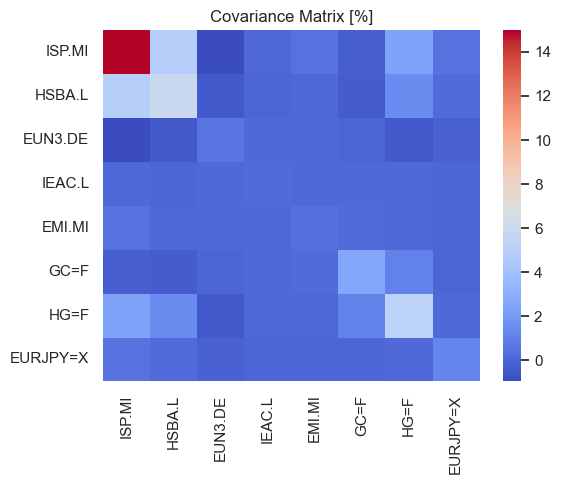

In [ ]:
plt.figure(figsize=(6, 5))
plt.title("Daily Covariance Matrix [%]")
sns.heatmap(log_returns.cov() * 252 * 100, cmap='coolwarm',
            annot=False, fmt=".2%")
plt.tight_layout()
plt.show()

It is good to see that most correlations are low, which is good for diversification. Also, the products have a relatively low volatility, which is also good for risk reduction.

## Static Allocation

For this section, we will use 5 historical years of data.

In [87]:
start_date = log_returns.index[-1] - relativedelta(years=5)
last_date = log_returns.index[-1]
start_date, last_date

(Timestamp('2020-03-14 00:00:00'), Timestamp('2025-03-14 00:00:00'))

In [88]:
log_returns = log_returns.loc[start_date:last_date]
log_returns.head(2)

,ISP.MI,HSBA.L,EUN3.DE,IEAC.L,EMI.MI,GC=F,HG=F,EURJPY=X
2020-03-16,-0.102619,-0.003118,-0.006056,-0.027598,-0.035395,-0.019857,-0.030993,0.017108
2020-03-17,0.034059,0.063104,0.006445,-0.014049,-0.008023,0.025908,-0.035218,-0.004300


### MC simulation

In [90]:
number_of_assets = len(log_returns.columns)
number_of_assets

8

In [92]:
def portfolio_returns (weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

def portfolio_volatility (weights, log_returns):
    return np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

In [93]:
Portfolio = namedtuple('Portfolio', ['returns', 'volatility'])

portfolios = [
    Portfolio(
        returns = portfolio_returns( 
                    weights := (w:= np.random.random(number_of_assets)) / np.sum(w),
                    log_returns= log_returns
        ),
        volatility = portfolio_volatility(weights, log_returns)
    )
    for _ in range(100_000)
]

df_portfolios = pd.DataFrame(portfolios)

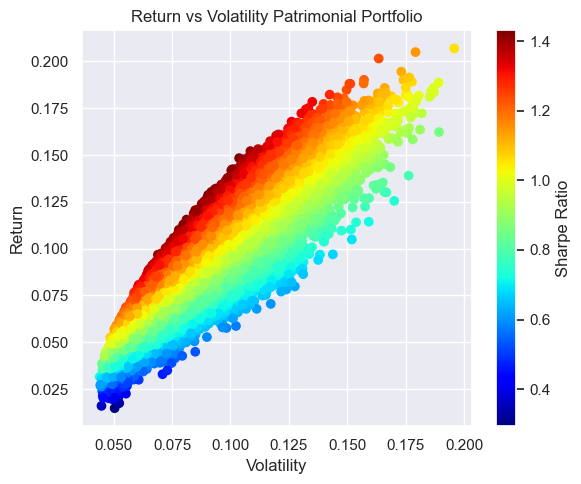

In [94]:
plt.figure(figsize=(6, 5))
plt.title("Return vs Volatility Patrimonial Portfolio")
plt.scatter(df_portfolios.volatility, df_portfolios.returns, 
            c=df_portfolios.returns / df_portfolios.volatility,
            cmap='jet', marker='o', alpha=1)
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.colorbar(label="Sharpe Ratio")
plt.tight_layout()
plt.show()

Given the nature of the problem now, we want to maximize returns, but considering that we want to minimize the risk. I will further, and set a threshold for the risk, so we get a safe investment portfolio, comparable to carmignac one.

I will still search for the best sharpe ratio, but now I will also add a constraint for the risk. I will set the **risk to be 7% maximum** for the portfolio, since this is the value of carmignac patrimoine.

In [134]:
expected_max_vol = 0.07

In [135]:
def portfolio_returns (weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252
def portfolio_volatility (weights, log_returns):
    return np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
def min_func_sharpe(weights, log_returns):
    return -portfolio_returns(weights, log_returns) / portfolio_volatility(weights, log_returns)

bounds = tuple((0, 1) for _ in range(number_of_assets))

eq_constraints = {
    'type': 'eq',
    'fun': lambda x: np.sum(x) - 1
} 
ineq_constraints = {
    'type': 'ineq',
    'fun': lambda x: expected_max_vol - portfolio_volatility(x, log_returns) 
}

initial_guess = number_of_assets * [1. / number_of_assets]

opt_sharpe = sco.minimize(
    min_func_sharpe,
    x0 = initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=[eq_constraints, ineq_constraints],
    args=(log_returns,)
)

x_sharpe = np.array([ value if value > 1e-7 else 0 for value in opt_sharpe.x ])
x_sharpe /= np.sum(x_sharpe)

print("Optimal Sharpe", -1 * opt_sharpe['fun'])
print("Min vol returns", portfolio_returns(x_sharpe, log_returns))
print("Min vol volatility", portfolio_volatility(x_sharpe, log_returns))

Optimal Sharpe 1.4186094920837413
Min vol returns 0.0993026945044512
Min vol volatility 0.07000002118876933


In [136]:
x_sharpe = np.array([ value if value > 1e-7 else 0 for value in opt_sharpe.x ])
x_sharpe /= np.sum(x_sharpe)
names = df.drop('Bench', axis=1).columns
pd.Series(x_sharpe, index=names)

ISP.MI      0.123632
HSBA.L      0.026337
EUN3.DE     0.091126
IEAC.L      0.000000
EMI.MI      0.156952
GC=F        0.212912
HG=F        0.017705
EURJPY=X    0.371337
dtype: float64

### Efficient Frontier

In [137]:
def fun_returns (weights, log_returns):
    return -portfolio_returns(weights, log_returns)

expected_volatilities = np.linspace(0.05, 0.25, 30)
optimal_returns = []
initial_guess = number_of_assets * [1. / number_of_assets]
bounds = tuple((0, 1) for asset in range(number_of_assets))

for expected_vol in expected_volatilities:
    constraints = (
        {
            'type' : 'eq',
            'fun' : lambda x: np.sum(x) - 1
        }, {
            'type' : 'eq',
            'fun' : lambda x: portfolio_volatility(x, log_returns) - expected_vol
        }
    )
    
    opt = sco.minimize(
        fun_returns,
        x0 = initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        args=(log_returns,)
    )
    optimal_returns.append(-opt['fun'])    

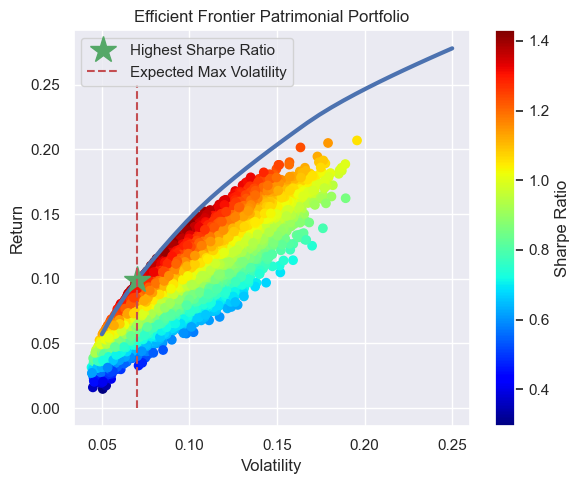

In [138]:
plt.figure(figsize=(6, 5))
plt.title("Efficient Frontier Patrimonial Portfolio")
plt.scatter(df_portfolios.volatility, df_portfolios.returns, 
            c=df_portfolios.returns / df_portfolios.volatility,
            cmap='jet', marker='o', alpha=1)
plt.plot(expected_volatilities, optimal_returns, lw=3)
plt.plot(portfolio_volatility(x_sharpe, log_returns), portfolio_returns(x_sharpe, log_returns), 
         'g*', markersize=20.0, label="Highest Sharpe Ratio")
plt.vlines(expected_max_vol, 0, 0.25, linestyles='dashed', colors='r', label="Expected Max Volatility")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.colorbar(label="Sharpe Ratio")
plt.tight_layout()
plt.legend()
plt.show()

Lets check for the benchmark

In [139]:
log_returns_benchmark = df['Bench'].to_log_returns().dropna().loc[start_date:last_date]
log_returns_benchmark.head(2)

2020-03-16   -0.011720
2020-03-17   -0.012511
Name: Bench, dtype: float64

In [140]:
print("Benchmark returns", log_returns_benchmark.mean() * 252 * 100 , "%")
print("Benchmark volatility", log_returns_benchmark.std() * np.sqrt(252) * 100, "%")
print("Benchmark Sharpe", (log_returns_benchmark.mean() * 252) / (log_returns_benchmark.std() * np.sqrt(252)))

Benchmark returns 3.9065868478797534 %
Benchmark volatility 7.019192082892618 %
Benchmark Sharpe 0.5565579060588756


We can see that with the same volatility, with our portfolio, we can get higher returns. This is a good result, but we might not be considering some other important parameters like max drawdown and the CVaR of the portfolio.

## Dynamic Allocation & Leverage

We will be using the same methodology as before, but now we will be using the patrimonial portfolio.

In [154]:
max_risk_daily = 0.07

Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2020-09-01 | End date: 2025-02-28

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 36.05% 	 | 6.58%
Yearly Return:	   | 6.30% 	 | 0.51%
Yearly Volatility: | 8.11% 	 | 6.29%
Yearly Sharpe:	   | 0.78	 | 0.08
CAGR:		   | 7.09% 	 | 1.43%
Max Drawdown:	   | -9.87% 	 | -18.20%


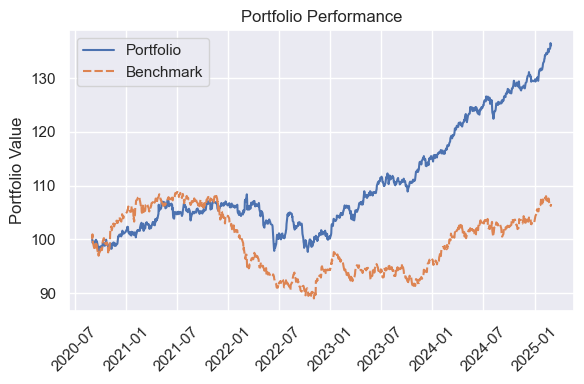

In [155]:
dynamic_optimizer = PortfolioOptimizer(
    prices = df.drop('Bench', axis=1),
    benchmark_series = df['Bench'],
    num_periods = 10,
    rebalance_period = 6,
    history_window = 12,
    month_offset_from_today = 1,
    max_risk = max_risk_daily,
)

results_df, overall_stats, portfolio_series = dynamic_optimizer.run_backtest(
    display_stats=True, 
    display_graph=True
)

In [156]:
results_df.head()

,Date,Portfolio Value (%),Portfolio Daily Return (%),Portfolio Daily Volatility (%),Portfolio Daily Sharpe,Portfolio Kelly,Portfolio VaR,Portfolio CVaR,Target Volatility,Max Drawdown
0,2020-08-28,2.33,11.27,6.37,1.77,27.803910,-0.006687,-0.008013,2.355830,-0.059908
1,2021-02-28,3.00,14.07,6.49,2.17,33.363555,-0.005674,-0.008215,2.309574,-0.067746
2,2021-08-28,0.30,9.29,3.36,2.76,82.100825,-0.004782,-0.006957,3.000000,-0.016601
3,2022-02-28,-3.45,8.83,4.77,1.85,38.775611,-0.008192,-0.013616,3.000000,-0.024545
4,2022-08-28,4.39,9.68,7.57,1.28,16.878794,-0.007908,-0.008929,1.980830,-0.041717


Month lag: 1
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-08-29 | End date: 2025-02-28

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 69.13% 	 | 32.26%
Yearly Return:	   | 4.32% 	 | 2.43%
Yearly Volatility: | 6.23% 	 | 6.98%
Yearly Sharpe:	   | 0.69	 | 0.35
CAGR:		   | 4.29% 	 | 2.26%
Max Drawdown:	   | -10.71% 	 | -20.49%


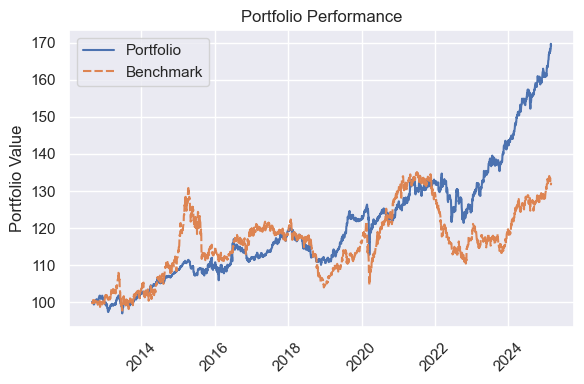

Month lag: 2
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-08-01 | End date: 2025-01-31

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 50.83% 	 | 31.11%
Yearly Return:	   | 3.59% 	 | 2.47%
Yearly Volatility: | 6.00% 	 | 6.99%
Yearly Sharpe:	   | 0.60	 | 0.35
CAGR:		   | 3.34% 	 | 2.19%
Max Drawdown:	   | -13.80% 	 | -20.49%


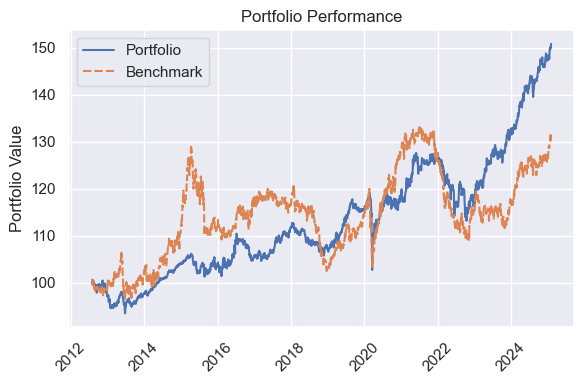

Month lag: 3
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-07-02 | End date: 2024-12-30

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 49.68% 	 | 28.65%
Yearly Return:	   | 3.78% 	 | 2.36%
Yearly Volatility: | 6.51% 	 | 7.29%
Yearly Sharpe:	   | 0.58	 | 0.32
CAGR:		   | 3.28% 	 | 2.04%
Max Drawdown:	   | -14.42% 	 | -20.49%


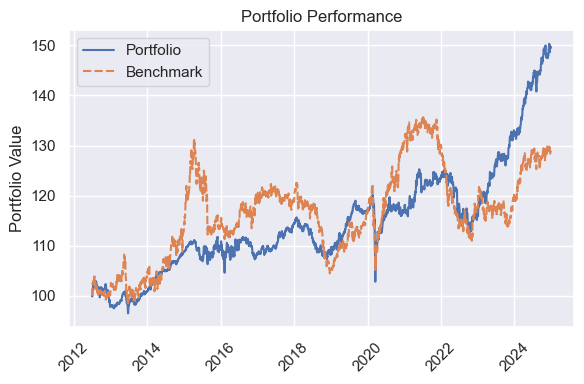

Month lag: 4
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-05-31 | End date: 2024-11-29

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 64.48% 	 | 26.08%
Yearly Return:	   | 4.64% 	 | 2.35%
Yearly Volatility: | 6.07% 	 | 7.28%
Yearly Sharpe:	   | 0.76	 | 0.32
CAGR:		   | 4.06% 	 | 1.87%
Max Drawdown:	   | -12.55% 	 | -20.49%


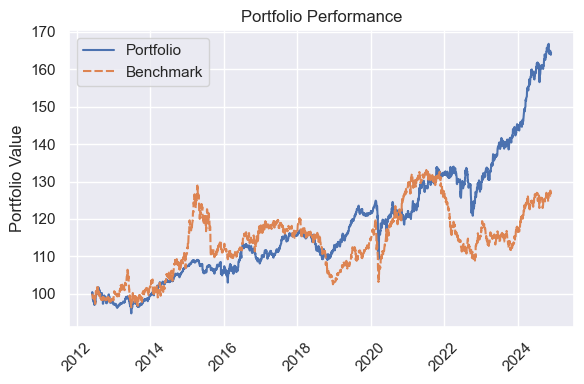

Month lag: 5
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-05-02 | End date: 2024-10-30

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 50.43% 	 | 28.77%
Yearly Return:	   | 3.31% 	 | 2.29%
Yearly Volatility: | 6.36% 	 | 7.24%
Yearly Sharpe:	   | 0.52	 | 0.32
CAGR:		   | 3.32% 	 | 2.04%
Max Drawdown:	   | -12.05% 	 | -20.49%


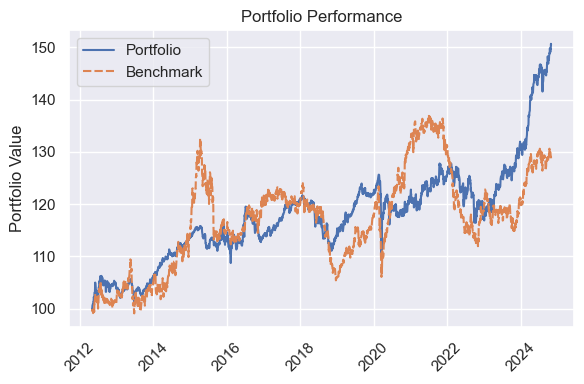

Month lag: 6
Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2012-04-02 | End date: 2024-09-30

	          | Portfolio	 | Benchmark
----------------------------------------------------------------------
Total Return:	   | 53.75% 	 | 30.24%
Yearly Return:	   | 3.19% 	 | 2.25%
Yearly Volatility: | 5.15% 	 | 7.22%
Yearly Sharpe:	   | 0.62	 | 0.31
CAGR:		   | 3.50% 	 | 2.14%
Max Drawdown:	   | -10.32% 	 | -20.49%


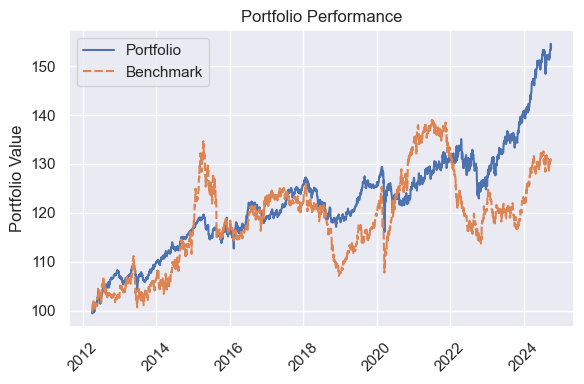

In [157]:
list_results = []

for month_lag in range(1, 7):
    print(f"Month lag: {month_lag}")
    dynamic_optimizer = PortfolioOptimizer(
        prices = df.drop('Bench', axis=1),
        benchmark_series = df['Bench'],
        num_periods = 100,
        rebalance_period = 6,
        history_window = 12,
        month_offset_from_today = month_lag,
        max_risk= max_risk_daily
    )

    results_df, overall_stats, portfolio_series = dynamic_optimizer.run_backtest(
        display_stats=True, 
        display_graph=True
    )
    results_df['Month_lag'] = month_lag
    list_results.append(results_df)
    
df_results = pd.concat(list_results)

In [158]:
df_results.shape

(150, 11)

In [159]:
df_results.head()

,Date,Portfolio Value (%),Portfolio Daily Return (%),Portfolio Daily Volatility (%),Portfolio Daily Sharpe,Portfolio Kelly,Portfolio VaR,Portfolio CVaR,Target Volatility,Max Drawdown,Month_lag
0,2012-08-28,-0.87,10.46,4.25,2.46,57.890823,-0.004222,-0.007348,3.0,-0.026406,1
1,2013-02-28,-0.44,8.57,3.34,2.56,76.694441,-0.004165,-0.006499,3.0,-0.018879,1
2,2013-08-28,4.04,11.15,4.42,2.52,57.106978,-0.002760,-0.003706,3.0,-0.039751,1
3,2014-02-28,3.76,10.41,3.49,2.98,85.226400,-0.002216,-0.003012,3.0,-0.040150,1
4,2014-08-28,3.89,9.60,1.98,4.84,244.461824,-0.001554,-0.002233,3.0,-0.007833,1


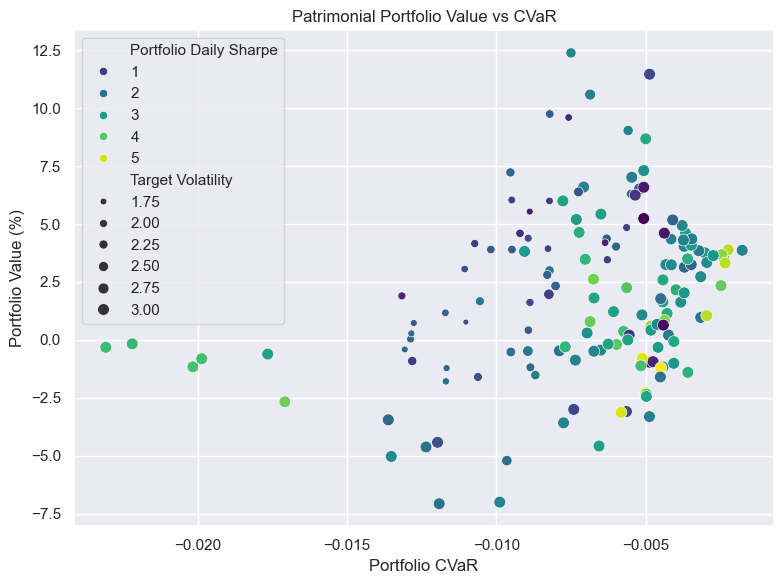

In [160]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_results,
                x = 'Portfolio CVaR', y="Portfolio Value (%)",
                size = 'Target Volatility', hue='Portfolio Daily Sharpe', palette='viridis')
plt.title("Patrimonial Portfolio Value vs CVaR")
plt.tight_layout()

In [161]:
df_results['leverage'] = ( df_results['Portfolio Value (%)'] > 0.5 ).astype(int)
df_results.tail()

,Date,Portfolio Value (%),Portfolio Daily Return (%),Portfolio Daily Volatility (%),Portfolio Daily Sharpe,Portfolio Kelly,Portfolio VaR,Portfolio CVaR,Target Volatility,Max Drawdown,Month_lag,leverage
20,2022-03-30,-7.07,10.03,4.81,2.08,43.303454,-0.009428,-0.011910,3.000000,-0.036973,6,0
21,2022-09-30,4.16,7.33,7.40,0.99,13.378089,-0.006734,-0.010720,2.026942,-0.043154,6,1
22,2023-03-30,4.20,4.65,7.85,0.59,7.539114,-0.005023,-0.006353,1.910598,-0.050181,6,1
23,2023-09-30,9.04,14.43,5.91,2.44,41.341869,-0.004216,-0.005582,2.538528,-0.030451,6,1
24,2024-03-30,4.64,15.10,4.37,3.46,79.182266,-0.004823,-0.007223,3.000000,-0.023629,6,1


In [162]:
df_results['leverage'].value_counts()

leverage
1    92
0    58
Name: count, dtype: int64

Best parameters: OrderedDict([('alpha', 0), ('colsample_bytree', 1.0), ('gamma', 0.07838579189743496), ('lambda', 1), ('learning_rate', 0.03782795055991671), ('max_depth', 4), ('min_child_weight', 1), ('n_estimators', 561), ('scale_pos_weight', 8), ('subsample', 0.9163471707009401)])
Best score: 0.8183760683760684
Accuracy: 0.8
F1 Score: 0.8301886792452831
Confusion Matrix:
[[14  4]
 [ 5 22]]


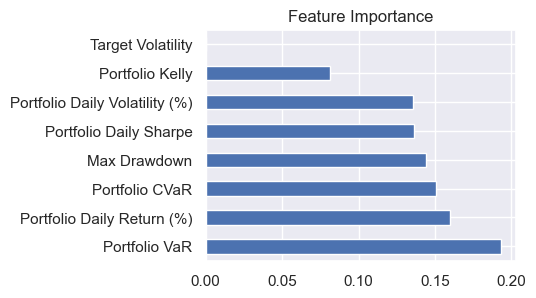

In [163]:
X_train, X_test, y_train, y_test = train_test_split(
    df_results.drop(columns=['Portfolio Value (%)', 'Date', 'Month_lag', 'leverage']),
    df_results['leverage'],
    test_size=0.3,
    random_state=42
)

param_grid = {
    'n_estimators': (400, 600),
    'learning_rate': (0.01, 0.07),
    'max_depth': (1, 7),
    'min_child_weight': (1, 5),
    'gamma': (0, 0.5),
    'subsample': (0.8, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'lambda': (0, 2),
    'alpha': (0, 1),
    'scale_pos_weight' : (1, 10),
}

bayes_search = BayesSearchCV(
    xgb.XGBClassifier(),
    param_grid,
    n_iter=32,
    cv=4,
    n_jobs=-1,
    verbose=0
)
bayes_search.fit(X_train, y_train)
best_clf = bayes_search.best_estimator_
print("Best parameters:", bayes_search.best_params_)
print("Best score:", bayes_search.best_score_)

y_pred = best_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# feature importance
plt.figure(figsize=(4, 3))
feature_importance = pd.Series(best_clf.feature_importances_, index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [165]:
df.head()

,ISP.MI,HSBA.L,EUN3.DE,IEAC.L,EMI.MI,GC=F,HG=F,EURJPY=X,Bench
2010-03-17,1.174419,642.908203,67.886612,93.870476,116.811989,1124.000000,3.4100,124.184998,498.81
2010-03-18,1.172403,631.958008,68.285789,93.894714,116.552208,1127.400024,3.3875,123.160004,500.26
2010-03-19,1.144176,631.030151,68.450684,93.910873,116.392342,1107.400024,3.3645,122.519997,500.29
2010-03-22,1.130064,629.266541,68.528786,94.023979,116.352379,1099.300049,3.3725,122.550003,499.96
2010-03-23,1.120991,627.132385,68.685005,94.056282,116.841957,1103.500000,3.3695,121.680000,500.91


Month lag: 1
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 2
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 3
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 4
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 5
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 6
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 1
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 2
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 3
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 4
Starting Dynamic Portfolio Optimization:
----------------------------------------
Month lag: 5
Starting Dynamic Portfolio Optimizati

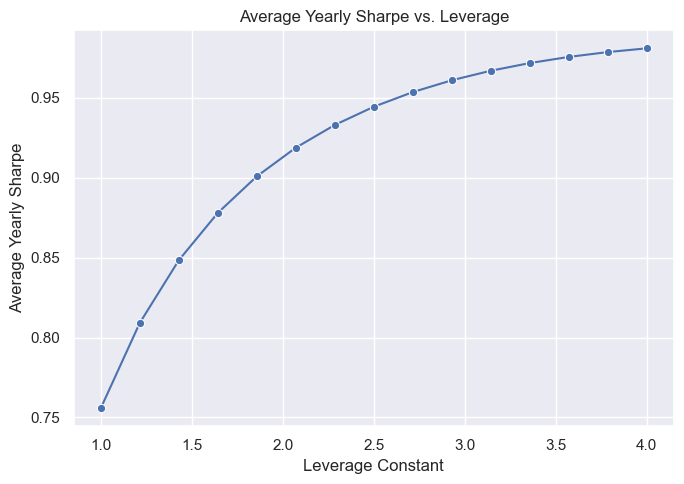

In [164]:
leverages_results = []
for leverage in np.linspace(1, 4, 15):
    period_sharpes = []
    for month_lag in range(1, 7):
        print(f"Month lag: {month_lag}")

        dynamic_optimizer = PortfolioOptimizer(
            prices = df.drop('Bench', axis=1),
            benchmark_series = df['Bench'],
            num_periods = 10,
            rebalance_period = 6,
            history_window = 12,
            month_offset_from_today = month_lag,
            leverage_const=leverage,
            leverage_model=best_clf,
            max_risk=max_risk_daily
        )
        _, end_stats, _ = dynamic_optimizer.run_backtest(display_stats=False, display_graph=False)
        
        period_sharpes.append(end_stats["Yearly Sharpe"])
    leverages_results.append({
        'avg_sharpe': np.mean(period_sharpes),
        'leverage': leverage
    })

df_leverage_results = pd.DataFrame(leverages_results)
sns.lineplot(data=df_leverage_results, x="leverage", y="avg_sharpe", marker="o")
plt.title("Average Yearly Sharpe vs. Leverage")
plt.xlabel("Leverage Constant")
plt.ylabel("Average Yearly Sharpe")
plt.tight_layout()
plt.show()

Again, I will choose 2.5 as the leverage factor. This is a completely arbitrary decision.

Starting Dynamic Portfolio Optimization:
----------------------------------------
Portfolio Stats:
Init date: 2020-09-01 | End date: 2025-02-28

	           | Portfolio	 | Benchmark	 | Leverage Portfolio
------------------------------------------------------------------------------------------
Total Return:	   | 36.05%	 | 6.58%	 | 121.70%
Yearly Return:	   | 6.30%	 | 0.51%	 | 17.80%
Yearly Volatility: | 8.11%	 | 6.29%	 | 19.62%
Yearly Sharpe:	   | 0.78	 | 0.08		 | 0.91
CAGR:		   | 7.09%	 | 1.43%	 | 19.39%
Max Drawdown:	   | -9.87%	 | -18.20%	 | -17.17%


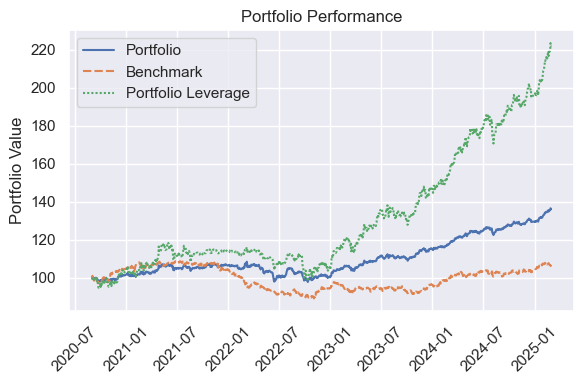

In [167]:
dynamic_optimizer = PortfolioOptimizer(
        prices = df.drop('Bench', axis=1),
        benchmark_series = df['Bench'],
        num_periods = 10,
        rebalance_period = 6,
        history_window = 12,
        month_offset_from_today = 1,
        leverage_const=2.5,
        leverage_model=best_clf,
        max_risk=max_risk_daily
    )

_, end_stats, _ = dynamic_optimizer.run_backtest(display_stats=True, display_graph=True)

The results are clear. It is important to notice how much the risk increases with the leverage. In other words, when we are building a low risk portfolio, where we want to control the risk, using leverage makes more difficult this mission. Therefore, extreme care must be taken when using leverage in a low risk portfolio.

# Conclusion